## Load libraries

In [97]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
# from gensim.utils import ClippedCorpus

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from pprint import pprint
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
from cluster_visualization_helper import (
    compute_cluster_visualization,
    visualize_cluster)  # user-defined functions

# Libraries for evaluation
from gensim.models import CoherenceModel
from sklearn import metrics

# Libraries for monitoring operation process
from tqdm import tqdm
from datetime import datetime
import warnings

## Configurate and declare global variables

In [98]:
os_name = os.name

if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline
warnings.filterwarnings('ignore')

## Import data

In [46]:
# title_embeddings_matrix = np.load(OUTPUT_DIR + "title_embeddings_distance_matrix.npy")
# title_embeddings_matrix.shape

In [47]:
title_embeddings = np.load(OUTPUT_DIR + "title_embeddings.npy")
# Load clean job title dataset from file
title_docs = pd.read_csv(
    OUTPUT_DIR + "clean_title_df.csv",
    converters={
        "job_title_token": ast.literal_eval,
    },
    dtype={
        "job_id": int,
        "job_title": str,
        "job_title_lemma": str,
    }
)

In [48]:
title_embeddings.shape, title_docs.shape

((18992, 300), (18992, 4))

In [49]:
title_docs

,job_id,job_title,job_title_lemma,job_title_token
0,1,Chief Financial Officer,chief financial officer,"[chief, financial, officer]"
1,2,Full-time Community Connections Intern (paid i...,time community connection intern pay internship,"[time, community, connection, intern, pay, int..."
2,3,Country Coordinator,country coordinator,"[country, coordinator]"
3,4,BCC Specialist,bcc specialist,"[bcc, specialist]"
4,5,Software Developer,software developer,"[software, developer]"
...,...,...,...,...
18987,18997,Senior Creative UX/ UI Designer,senior creative ux ui designer,"[senior, creative, ux, ui, designer]"
18988,18998,Category Development Manager,category development manager,"[category, development, manager]"
18989,18999,Operational Marketing Manager,operational marketing manager,"[operational, marketing, manager]"
18990,19000,Head of Online Sales Department,head online sale department,"[head, online, sale, department]"


## Clustering data

### Latent Dirichlet Allocation (LDA) 

In [50]:
# Create doc list of clean job titles
doc_list = title_docs["job_title_lemma"].values.tolist()
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
title_corpus = title_docs["job_title_token"].values.tolist()
pprint(title_corpus[:10])

# Create Dictionary
id2word = Dictionary(title_corpus)

# Term Document Frequency
lda_corpus = [id2word.doc2bow(text) for text in title_corpus]
pprint(lda_corpus[:3])

['chief financial officer',
 'time community connection intern pay internship',
 'country coordinator',
 'bcc specialist',
 'software developer',
 'saleswoman',
 'chief accountant finance assistant',
 'non pay time programmatic intern',
 'assistant manage director',
 'program assistant inl fsn fp']
[['chief', 'financial', 'officer'],
 ['time', 'community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 ['bcc', 'specialist'],
 ['software', 'developer'],
 ['saleswoman'],
 ['chief', 'accountant', 'finance', 'assistant'],
 ['non', 'pay', 'time', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant', 'inl', 'fsn', 'fp']]
[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1)]]


In [51]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in lda_corpus[:3]]

[[('chief', 1), ('financial', 1), ('officer', 1)],
 [('community', 1),
  ('connection', 1),
  ('intern', 1),
  ('internship', 1),
  ('pay', 1),
  ('time', 1)],
 [('coordinator', 1), ('country', 1)]]

In [146]:
def build_lda_model(dictionary, corpus, n_topics, alpha, beta):
    """
    Build LDA Topic model

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    n_topics: number of topics
    alpha: Dirichlet hyperparameter alpha (Document-Topic Density)
    beta: Dirichlet hyperparameter beta (Word-Topic Density)

    Returns:
    -------
    model: LDA topic models
    """

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=SEED,
#         update_every=1,
#         chunksize=1000,
        passes=50,
        alpha=alpha,
        eta=beta,
        iterations=100,
        minimum_probability=0
    )

    return model

In [147]:
# Preparing hyperparameters for tuning
grid = {}
# grid["Validation_Set"] = {}

# Topics range
# min_topics = 2
# max_topics = 101
# step_size = 10
# topics_range = range(min_topics, max_topics, step_size)
topic_range = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300]

# Alpha parameter
alpha_range = [0.001, 0.01, 0.25, 0.5]
# alpha.append("symmetric")
# alpha.append("asymmetric")

# Beta parameter
beta_range = [0.001, 0.01, 0.25, 0.5]
# beta.append("symmetric")

# Validation sets
# num_of_docs = len(lda_corpus)
# corpus_sets = [ClippedCorpus(lda_corpus, int(num_of_docs * 0.75)), lda_corpus]
# corpus_title = ["75% Corpus", "100% Corpus"]
tuning_result = {
    #     "Validation_Set_no": [],
    #     "Validation_Set": [],
    "n_topics": [],
    #     "Alpha_num": [],
    "alpha": [],
    #     "Beta_num": [],
    "beta": [],
    "duration": [],
}

model_list = []

In [148]:
# len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
print(topic_range)
print(alpha_range)
print(beta_range)
print(
    len(topic_range),
    len(alpha_range),
    len(beta_range),
    len(topic_range) * len(alpha_range) * len(beta_range),
)

[5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300]
[0.001, 0.01, 0.25, 0.5]
[0.001, 0.01, 0.25, 0.5]
12 4 4 192


In [149]:
# Tuning LDA to find optimal number of topics
pbar = tqdm(
    desc="LDA tuning",
    total=len(topic_range) * len(alpha_range) * len(beta_range),
)

# iterate through number of topics
for n_topics in topic_range:
    # iterate through alpha values
    for ida, alpha in enumerate(alpha_range):
        # iterare through beta values
        for idb, beta in enumerate(beta_range):

            # Train model
            starttime = datetime.now()
            print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
            print("n_topics =", n_topics)
            print("alpha =", alpha)
            print("beta =", beta)

            # get the coherence score and perplexity for the given parameters
            clusterer = build_lda_model(
                dictionary=id2word,
                corpus=lda_corpus,
                n_topics=n_topics,
                alpha=alpha,
                beta=beta,
            )

            endtime = datetime.now()
            print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
            print("Duration", endtime - starttime)

            #             cv_score, perplexity = compute_evaluation_metrics(
            #                 clusterer,
            #                 corpus=lda_corpus,
            #                 dictionary=id2word,
            #                 texts=title_corpus,
            #             )

            # Save model
            pickle.dump(
                clusterer,
                open(
                    OUTPUT_DIR
                    + "lda/"
                    + "title_lda_model_n_topics-"
                    + str(n_topics)
                    + "_alpha-"
                    + str(alpha)
                    + "_beta-"
                    + str(beta)
                    + ".pkl",
                    "wb",
                ),
            )

            model_list.append(clusterer)

            # Save the model results
            #             tuning_result["Validation_Set_no"].append(i)
            #             model_results["Validation_Set"].append(corpus_title[i])
            tuning_result["n_topics"].append(n_topics)
            #             tuning_result["Alpha_num"].append(ida)
            tuning_result["alpha"].append(alpha)
            #             tuning_result["Beta_num"].append(idb)
            tuning_result["beta"].append(beta)
            #             tuning_result["coherence"].append(cv_score)
            #             tuning_result["perplexity"].append(perplexity)
            tuning_result["duration"].append(
                round((endtime - starttime).seconds / 60, 4)
            )

            pbar.update(1)
pbar.close()

LDA tuning:   0%|                                                                              | 0/192 [00:00<?, ?it/s]

Start 2021-05-18 18:25:25.082289
n_topics = 5
alpha = 0.001
beta = 0.001


LDA tuning:   1%|▎                                                                   | 1/192 [01:19<4:12:40, 79.37s/it]

End 2021-05-18 18:26:44.287006
Duration 0:01:19.204717
Start 2021-05-18 18:26:44.455462
n_topics = 5
alpha = 0.001
beta = 0.01


LDA tuning:   1%|▋                                                                   | 2/192 [02:39<4:13:06, 79.93s/it]

End 2021-05-18 18:28:04.687506
Duration 0:01:20.232044
Start 2021-05-18 18:28:04.773138
n_topics = 5
alpha = 0.001
beta = 0.25


LDA tuning:   2%|█                                                                   | 3/192 [04:03<4:16:45, 81.51s/it]

End 2021-05-18 18:29:28.082226
Duration 0:01:23.309088
Start 2021-05-18 18:29:28.164797
n_topics = 5
alpha = 0.001
beta = 0.5


LDA tuning:   2%|█▍                                                                  | 4/192 [05:31<4:24:05, 84.28s/it]

End 2021-05-18 18:30:56.691425
Duration 0:01:28.526628
Start 2021-05-18 18:30:56.696307
n_topics = 5
alpha = 0.01
beta = 0.001


LDA tuning:   3%|█▊                                                                  | 5/192 [06:50<4:16:39, 82.35s/it]

End 2021-05-18 18:32:15.475755
Duration 0:01:18.779448
Start 2021-05-18 18:32:15.615236
n_topics = 5
alpha = 0.01
beta = 0.01


LDA tuning:   3%|██▏                                                                 | 6/192 [08:07<4:09:35, 80.52s/it]

End 2021-05-18 18:33:32.570291
Duration 0:01:16.955055
Start 2021-05-18 18:33:32.575267
n_topics = 5
alpha = 0.01
beta = 0.25


LDA tuning:   4%|██▍                                                                 | 7/192 [09:30<4:10:20, 81.19s/it]

End 2021-05-18 18:34:55.082522
Duration 0:01:22.507255
Start 2021-05-18 18:34:55.156528
n_topics = 5
alpha = 0.01
beta = 0.5


LDA tuning:   4%|██▊                                                                 | 8/192 [10:55<4:13:10, 82.56s/it]

End 2021-05-18 18:36:20.480957
Duration 0:01:25.324429
Start 2021-05-18 18:36:20.643989
n_topics = 5
alpha = 0.25
beta = 0.001


LDA tuning:   5%|███▏                                                                | 9/192 [12:19<4:13:23, 83.08s/it]

End 2021-05-18 18:37:44.770119
Duration 0:01:24.126130
Start 2021-05-18 18:37:44.864794
n_topics = 5
alpha = 0.25
beta = 0.01


LDA tuning:   5%|███▍                                                               | 10/192 [13:46<4:15:46, 84.32s/it]

End 2021-05-18 18:39:11.955514
Duration 0:01:27.090720
Start 2021-05-18 18:39:11.967508
n_topics = 5
alpha = 0.25
beta = 0.25


LDA tuning:   6%|███▊                                                               | 11/192 [15:20<4:23:10, 87.24s/it]

End 2021-05-18 18:40:45.831627
Duration 0:01:33.864119
Start 2021-05-18 18:40:45.837669
n_topics = 5
alpha = 0.25
beta = 0.5


LDA tuning:   6%|████▏                                                              | 12/192 [16:57<4:30:42, 90.23s/it]

End 2021-05-18 18:42:22.869611
Duration 0:01:37.031942
Start 2021-05-18 18:42:22.908578
n_topics = 5
alpha = 0.5
beta = 0.001


LDA tuning:   7%|████▌                                                              | 13/192 [17:59<4:03:34, 81.64s/it]

End 2021-05-18 18:43:24.782610
Duration 0:01:01.874032
Start 2021-05-18 18:43:24.786653
n_topics = 5
alpha = 0.5
beta = 0.01


LDA tuning:   7%|████▉                                                              | 14/192 [19:11<3:53:27, 78.69s/it]

End 2021-05-18 18:44:36.657305
Duration 0:01:11.870652
Start 2021-05-18 18:44:36.663307
n_topics = 5
alpha = 0.5
beta = 0.25


LDA tuning:   8%|█████▏                                                             | 15/192 [20:30<3:52:36, 78.85s/it]

End 2021-05-18 18:45:55.876511
Duration 0:01:19.213204
Start 2021-05-18 18:45:55.881511
n_topics = 5
alpha = 0.5
beta = 0.5
End 2021-05-18 18:47:32.992564
Duration 0:01:37.111053


LDA tuning:   8%|█████▌                                                             | 16/192 [22:09<4:08:44, 84.80s/it]

Start 2021-05-18 18:47:34.497570
n_topics = 10
alpha = 0.001
beta = 0.001


LDA tuning:   9%|█████▉                                                             | 17/192 [23:58<4:29:01, 92.24s/it]

End 2021-05-18 18:49:23.956632
Duration 0:01:49.459062
Start 2021-05-18 18:49:24.022636
n_topics = 10
alpha = 0.001
beta = 0.01


LDA tuning:   9%|██████▎                                                            | 18/192 [25:46<4:40:25, 96.70s/it]

End 2021-05-18 18:51:11.109748
Duration 0:01:47.087112
Start 2021-05-18 18:51:11.113699
n_topics = 10
alpha = 0.001
beta = 0.25


LDA tuning:  10%|██████▋                                                            | 19/192 [27:11<4:28:55, 93.27s/it]

End 2021-05-18 18:52:36.395762
Duration 0:01:25.282063
Start 2021-05-18 18:52:36.398770
n_topics = 10
alpha = 0.001
beta = 0.5


LDA tuning:  10%|██████▉                                                            | 20/192 [28:38<4:22:21, 91.52s/it]

End 2021-05-18 18:54:03.735233
Duration 0:01:27.336463
Start 2021-05-18 18:54:03.831774
n_topics = 10
alpha = 0.01
beta = 0.001


LDA tuning:  11%|███████▎                                                           | 21/192 [30:00<4:12:30, 88.60s/it]

End 2021-05-18 18:55:25.620273
Duration 0:01:21.788499
Start 2021-05-18 18:55:25.627248
n_topics = 10
alpha = 0.01
beta = 0.01


LDA tuning:  11%|███████▋                                                           | 22/192 [31:31<4:12:45, 89.21s/it]

End 2021-05-18 18:56:56.242861
Duration 0:01:30.615613
Start 2021-05-18 18:56:56.248861
n_topics = 10
alpha = 0.01
beta = 0.25


LDA tuning:  12%|████████                                                           | 23/192 [33:05<4:15:40, 90.77s/it]

End 2021-05-18 18:58:30.665699
Duration 0:01:34.416838
Start 2021-05-18 18:58:30.669700
n_topics = 10
alpha = 0.01
beta = 0.5


LDA tuning:  12%|████████▍                                                          | 24/192 [34:42<4:19:16, 92.60s/it]

End 2021-05-18 19:00:07.431758
Duration 0:01:36.762058
Start 2021-05-18 19:00:07.529681
n_topics = 10
alpha = 0.25
beta = 0.001


LDA tuning:  13%|████████▋                                                          | 25/192 [36:07<4:11:31, 90.37s/it]

End 2021-05-18 19:01:32.608468
Duration 0:01:25.078787
Start 2021-05-18 19:01:32.699101
n_topics = 10
alpha = 0.25
beta = 0.01


LDA tuning:  14%|█████████                                                          | 26/192 [37:31<4:04:18, 88.31s/it]

End 2021-05-18 19:02:56.120446
Duration 0:01:23.421345
Start 2021-05-18 19:02:56.191372
n_topics = 10
alpha = 0.25
beta = 0.25


LDA tuning:  14%|█████████▍                                                         | 27/192 [39:00<4:03:28, 88.54s/it]

End 2021-05-18 19:04:25.236374
Duration 0:01:29.045002
Start 2021-05-18 19:04:25.267371
n_topics = 10
alpha = 0.25
beta = 0.5


LDA tuning:  15%|█████████▊                                                         | 28/192 [40:24<3:58:48, 87.37s/it]

End 2021-05-18 19:05:49.906235
Duration 0:01:24.638864
Start 2021-05-18 19:05:49.910235
n_topics = 10
alpha = 0.5
beta = 0.001


LDA tuning:  15%|██████████                                                         | 29/192 [41:41<3:48:27, 84.10s/it]

End 2021-05-18 19:07:06.367773
Duration 0:01:16.457538
Start 2021-05-18 19:07:06.372777
n_topics = 10
alpha = 0.5
beta = 0.01


LDA tuning:  16%|██████████▍                                                        | 30/192 [42:49<3:34:31, 79.45s/it]

End 2021-05-18 19:08:14.989812
Duration 0:01:08.617035
Start 2021-05-18 19:08:14.993813
n_topics = 10
alpha = 0.5
beta = 0.25


LDA tuning:  16%|██████████▊                                                        | 31/192 [44:03<3:28:28, 77.69s/it]

End 2021-05-18 19:09:28.574906
Duration 0:01:13.581093
Start 2021-05-18 19:09:28.579861
n_topics = 10
alpha = 0.5
beta = 0.5


LDA tuning:  17%|███████████▏                                                       | 32/192 [45:24<3:29:49, 78.69s/it]

End 2021-05-18 19:10:49.579908
Duration 0:01:21.000047
Start 2021-05-18 19:10:49.582908
n_topics = 15
alpha = 0.001
beta = 0.001


LDA tuning:  17%|███████████▌                                                       | 33/192 [47:04<3:45:24, 85.06s/it]

End 2021-05-18 19:12:29.436348
Duration 0:01:39.853440
Start 2021-05-18 19:12:29.517823
n_topics = 15
alpha = 0.001
beta = 0.01


LDA tuning:  18%|███████████▊                                                       | 34/192 [48:47<3:58:07, 90.43s/it]

End 2021-05-18 19:14:12.454916
Duration 0:01:42.937093
Start 2021-05-18 19:14:12.458879
n_topics = 15
alpha = 0.001
beta = 0.25


LDA tuning:  18%|████████████▏                                                      | 35/192 [50:27<4:04:07, 93.30s/it]

End 2021-05-18 19:15:52.458818
Duration 0:01:39.999939
Start 2021-05-18 19:15:52.462765
n_topics = 15
alpha = 0.001
beta = 0.5


LDA tuning:  19%|████████████▌                                                      | 36/192 [51:55<3:58:51, 91.87s/it]

End 2021-05-18 19:17:20.988145
Duration 0:01:28.525380
Start 2021-05-18 19:17:20.993112
n_topics = 15
alpha = 0.01
beta = 0.001


LDA tuning:  19%|████████████▉                                                      | 37/192 [53:20<3:51:36, 89.65s/it]

End 2021-05-18 19:18:45.470217
Duration 0:01:24.477105
Start 2021-05-18 19:18:45.474172
n_topics = 15
alpha = 0.01
beta = 0.01


LDA tuning:  20%|█████████████▎                                                     | 38/192 [54:50<3:50:09, 89.67s/it]

End 2021-05-18 19:20:15.103283
Duration 0:01:29.629111
Start 2021-05-18 19:20:15.193284
n_topics = 15
alpha = 0.01
beta = 0.25


LDA tuning:  20%|█████████████▌                                                     | 39/192 [56:24<3:51:55, 90.95s/it]

End 2021-05-18 19:21:49.123345
Duration 0:01:33.930061
Start 2021-05-18 19:21:49.127340
n_topics = 15
alpha = 0.01
beta = 0.5


LDA tuning:  21%|█████████████▉                                                     | 40/192 [58:05<3:58:20, 94.08s/it]

End 2021-05-18 19:23:30.503368
Duration 0:01:41.376028
Start 2021-05-18 19:23:30.507373
n_topics = 15
alpha = 0.25
beta = 0.001


LDA tuning:  21%|██████████████▎                                                    | 41/192 [59:25<3:45:56, 89.78s/it]

End 2021-05-18 19:24:50.236196
Duration 0:01:19.728823
Start 2021-05-18 19:24:50.241141
n_topics = 15
alpha = 0.25
beta = 0.01


LDA tuning:  22%|██████████████▏                                                  | 42/192 [1:00:48<3:39:35, 87.84s/it]

End 2021-05-18 19:26:13.551190
Duration 0:01:23.310049
Start 2021-05-18 19:26:13.559191
n_topics = 15
alpha = 0.25
beta = 0.25


LDA tuning:  22%|██████████████▌                                                  | 43/192 [1:02:22<3:42:24, 89.56s/it]

End 2021-05-18 19:27:47.129036
Duration 0:01:33.569845
Start 2021-05-18 19:27:47.133040
n_topics = 15
alpha = 0.25
beta = 0.5


LDA tuning:  23%|██████████████▉                                                  | 44/192 [1:03:56<3:44:17, 90.93s/it]

End 2021-05-18 19:29:21.242135
Duration 0:01:34.109095
Start 2021-05-18 19:29:21.246094
n_topics = 15
alpha = 0.5
beta = 0.001


LDA tuning:  23%|███████████████▏                                                 | 45/192 [1:05:11<3:30:57, 86.11s/it]

End 2021-05-18 19:30:36.108854
Duration 0:01:14.862760
Start 2021-05-18 19:30:36.113857
n_topics = 15
alpha = 0.5
beta = 0.01


LDA tuning:  24%|███████████████▌                                                 | 46/192 [1:06:18<3:15:56, 80.52s/it]

End 2021-05-18 19:31:43.595896
Duration 0:01:07.482039
Start 2021-05-18 19:31:43.599895
n_topics = 15
alpha = 0.5
beta = 0.25


LDA tuning:  24%|███████████████▉                                                 | 47/192 [1:07:25<3:04:48, 76.47s/it]

End 2021-05-18 19:32:50.613061
Duration 0:01:07.013166
Start 2021-05-18 19:32:50.619059
n_topics = 15
alpha = 0.5
beta = 0.5


LDA tuning:  25%|████████████████▎                                                | 48/192 [1:08:39<3:01:34, 75.66s/it]

End 2021-05-18 19:34:04.376108
Duration 0:01:13.757049
Start 2021-05-18 19:34:04.380103
n_topics = 20
alpha = 0.001
beta = 0.001


LDA tuning:  26%|████████████████▌                                                | 49/192 [1:10:06<3:08:42, 79.18s/it]

End 2021-05-18 19:35:31.672319
Duration 0:01:27.292216
Start 2021-05-18 19:35:31.777562
n_topics = 20
alpha = 0.001
beta = 0.01


LDA tuning:  26%|████████████████▉                                                | 50/192 [1:11:34<3:13:19, 81.69s/it]

End 2021-05-18 19:36:59.308597
Duration 0:01:27.531035
Start 2021-05-18 19:36:59.314596
n_topics = 20
alpha = 0.001
beta = 0.25


LDA tuning:  27%|█████████████████▎                                               | 51/192 [1:13:20<3:29:07, 88.99s/it]

End 2021-05-18 19:38:45.347021
Duration 0:01:46.032425
Start 2021-05-18 19:38:45.351974
n_topics = 20
alpha = 0.001
beta = 0.5


LDA tuning:  27%|█████████████████▌                                               | 52/192 [1:15:01<3:36:27, 92.77s/it]

End 2021-05-18 19:40:26.928788
Duration 0:01:41.576814
Start 2021-05-18 19:40:26.932781
n_topics = 20
alpha = 0.01
beta = 0.001


LDA tuning:  28%|█████████████████▉                                               | 53/192 [1:16:37<3:36:58, 93.66s/it]

End 2021-05-18 19:42:02.662656
Duration 0:01:35.729875
Start 2021-05-18 19:42:02.665655
n_topics = 20
alpha = 0.01
beta = 0.01


LDA tuning:  28%|██████████████████▎                                              | 54/192 [1:18:09<3:34:15, 93.16s/it]

End 2021-05-18 19:43:34.657280
Duration 0:01:31.991625
Start 2021-05-18 19:43:34.663296
n_topics = 20
alpha = 0.01
beta = 0.25


LDA tuning:  29%|██████████████████▌                                              | 55/192 [1:19:39<3:30:26, 92.17s/it]

End 2021-05-18 19:45:04.501265
Duration 0:01:29.837969
Start 2021-05-18 19:45:04.508259
n_topics = 20
alpha = 0.01
beta = 0.5


LDA tuning:  29%|██████████████████▉                                              | 56/192 [1:21:22<3:36:34, 95.55s/it]

End 2021-05-18 19:46:47.950134
Duration 0:01:43.441875
Start 2021-05-18 19:46:47.954084
n_topics = 20
alpha = 0.25
beta = 0.001


LDA tuning:  30%|███████████████████▎                                             | 57/192 [1:22:46<3:26:43, 91.88s/it]

End 2021-05-18 19:48:11.266136
Duration 0:01:23.312052
Start 2021-05-18 19:48:11.269133
n_topics = 20
alpha = 0.25
beta = 0.01


LDA tuning:  30%|███████████████████▋                                             | 58/192 [1:24:06<3:17:42, 88.53s/it]

End 2021-05-18 19:49:31.973204
Duration 0:01:20.704071
Start 2021-05-18 19:49:31.977168
n_topics = 20
alpha = 0.25
beta = 0.25


LDA tuning:  31%|███████████████████▉                                             | 59/192 [1:25:24<3:09:08, 85.33s/it]

End 2021-05-18 19:50:49.825460
Duration 0:01:17.848292
Start 2021-05-18 19:50:49.830479
n_topics = 20
alpha = 0.25
beta = 0.5


LDA tuning:  31%|████████████████████▎                                            | 60/192 [1:26:48<3:06:27, 84.76s/it]

End 2021-05-18 19:52:13.187562
Duration 0:01:23.357083
Start 2021-05-18 19:52:13.260903
n_topics = 20
alpha = 0.5
beta = 0.001


LDA tuning:  32%|████████████████████▋                                            | 61/192 [1:27:53<2:52:08, 78.84s/it]

End 2021-05-18 19:53:18.302155
Duration 0:01:05.041252
Start 2021-05-18 19:53:18.310159
n_topics = 20
alpha = 0.5
beta = 0.01


LDA tuning:  32%|████████████████████▉                                            | 62/192 [1:28:58<2:41:47, 74.67s/it]

End 2021-05-18 19:54:23.236245
Duration 0:01:04.926086
Start 2021-05-18 19:54:23.241196
n_topics = 20
alpha = 0.5
beta = 0.25


LDA tuning:  33%|█████████████████████▎                                           | 63/192 [1:30:08<2:37:53, 73.44s/it]

End 2021-05-18 19:55:33.798864
Duration 0:01:10.557668
Start 2021-05-18 19:55:33.805862
n_topics = 20
alpha = 0.5
beta = 0.5


LDA tuning:  33%|█████████████████████▋                                           | 64/192 [1:31:23<2:37:22, 73.77s/it]

End 2021-05-18 19:56:48.338938
Duration 0:01:14.533076
Start 2021-05-18 19:56:48.341938
n_topics = 25
alpha = 0.001
beta = 0.001


LDA tuning:  34%|██████████████████████                                           | 65/192 [1:32:49<2:43:58, 77.47s/it]

End 2021-05-18 19:58:14.351038
Duration 0:01:26.009100
Start 2021-05-18 19:58:14.451037
n_topics = 25
alpha = 0.001
beta = 0.01


LDA tuning:  34%|██████████████████████▎                                          | 66/192 [1:34:18<2:49:48, 80.86s/it]

End 2021-05-18 19:59:43.155130
Duration 0:01:28.704093
Start 2021-05-18 19:59:43.228110
n_topics = 25
alpha = 0.001
beta = 0.25


LDA tuning:  35%|██████████████████████▋                                          | 67/192 [1:36:00<3:01:54, 87.32s/it]

End 2021-05-18 20:01:25.607287
Duration 0:01:42.379177
Start 2021-05-18 20:01:25.612289
n_topics = 25
alpha = 0.001
beta = 0.5


LDA tuning:  35%|███████████████████████                                          | 68/192 [1:37:47<3:12:55, 93.35s/it]

End 2021-05-18 20:03:12.971251
Duration 0:01:47.358962
Start 2021-05-18 20:03:13.040162
n_topics = 25
alpha = 0.01
beta = 0.001


LDA tuning:  36%|███████████████████████▎                                         | 69/192 [1:39:13<3:06:30, 90.98s/it]

End 2021-05-18 20:04:38.488210
Duration 0:01:25.448048
Start 2021-05-18 20:04:38.492211
n_topics = 25
alpha = 0.01
beta = 0.01


LDA tuning:  36%|███████████████████████▋                                         | 70/192 [1:40:44<3:04:50, 90.91s/it]

End 2021-05-18 20:06:09.226283
Duration 0:01:30.734072
Start 2021-05-18 20:06:09.231271
n_topics = 25
alpha = 0.01
beta = 0.25


LDA tuning:  37%|████████████████████████                                         | 71/192 [1:42:21<3:07:13, 92.84s/it]

End 2021-05-18 20:07:46.471470
Duration 0:01:37.240199
Start 2021-05-18 20:07:46.568916
n_topics = 25
alpha = 0.01
beta = 0.5


LDA tuning:  38%|████████████████████████▍                                        | 72/192 [1:43:59<3:09:03, 94.53s/it]

End 2021-05-18 20:09:25.032981
Duration 0:01:38.464065
Start 2021-05-18 20:09:25.036976
n_topics = 25
alpha = 0.25
beta = 0.001


LDA tuning:  38%|████████████████████████▋                                        | 73/192 [1:45:22<3:00:21, 90.94s/it]

End 2021-05-18 20:10:47.595365
Duration 0:01:22.558389
Start 2021-05-18 20:10:47.599316
n_topics = 25
alpha = 0.25
beta = 0.01


LDA tuning:  39%|█████████████████████████                                        | 74/192 [1:46:37<2:49:09, 86.01s/it]

End 2021-05-18 20:12:02.108407
Duration 0:01:14.509091
Start 2021-05-18 20:12:02.113412
n_topics = 25
alpha = 0.25
beta = 0.25


LDA tuning:  39%|█████████████████████████▍                                       | 75/192 [1:48:01<2:46:41, 85.48s/it]

End 2021-05-18 20:13:26.361507
Duration 0:01:24.248095
Start 2021-05-18 20:13:26.370487
n_topics = 25
alpha = 0.25
beta = 0.5


LDA tuning:  40%|█████████████████████████▋                                       | 76/192 [1:49:41<2:54:01, 90.01s/it]

End 2021-05-18 20:15:06.951480
Duration 0:01:40.580993
Start 2021-05-18 20:15:06.955481
n_topics = 25
alpha = 0.5
beta = 0.001


LDA tuning:  40%|██████████████████████████                                       | 77/192 [1:51:01<2:46:40, 86.96s/it]

End 2021-05-18 20:16:26.781529
Duration 0:01:19.826048
Start 2021-05-18 20:16:26.785566
n_topics = 25
alpha = 0.5
beta = 0.01


LDA tuning:  41%|██████████████████████████▍                                      | 78/192 [1:52:13<2:36:20, 82.29s/it]

End 2021-05-18 20:17:38.173570
Duration 0:01:11.388004
Start 2021-05-18 20:17:38.179601
n_topics = 25
alpha = 0.5
beta = 0.25


LDA tuning:  41%|██████████████████████████▋                                      | 79/192 [1:53:27<2:30:38, 79.99s/it]

End 2021-05-18 20:18:52.782674
Duration 0:01:14.603073
Start 2021-05-18 20:18:52.786614
n_topics = 25
alpha = 0.5
beta = 0.5


LDA tuning:  42%|███████████████████████████                                      | 80/192 [1:54:46<2:28:28, 79.54s/it]

End 2021-05-18 20:20:11.292663
Duration 0:01:18.506049
Start 2021-05-18 20:20:11.298706
n_topics = 50
alpha = 0.001
beta = 0.001


LDA tuning:  42%|███████████████████████████▍                                     | 81/192 [1:56:28<2:39:42, 86.33s/it]

End 2021-05-18 20:21:53.466518
Duration 0:01:42.167812
Start 2021-05-18 20:21:53.472518
n_topics = 50
alpha = 0.001
beta = 0.01


LDA tuning:  43%|███████████████████████████▊                                     | 82/192 [1:58:11<2:47:24, 91.31s/it]

End 2021-05-18 20:23:36.313580
Duration 0:01:42.841062
Start 2021-05-18 20:23:36.399922
n_topics = 50
alpha = 0.001
beta = 0.25


LDA tuning:  43%|████████████████████████████                                     | 83/192 [2:00:10<3:00:56, 99.60s/it]

End 2021-05-18 20:25:35.351148
Duration 0:01:58.951226
Start 2021-05-18 20:25:35.355150
n_topics = 50
alpha = 0.001
beta = 0.5


LDA tuning:  44%|████████████████████████████                                    | 84/192 [2:02:15<3:13:22, 107.43s/it]

End 2021-05-18 20:27:41.029967
Duration 0:02:05.674817
Start 2021-05-18 20:27:41.034917
n_topics = 50
alpha = 0.01
beta = 0.001


LDA tuning:  44%|████████████████████████████▎                                   | 85/192 [2:03:53<3:06:27, 104.56s/it]

End 2021-05-18 20:29:18.901018
Duration 0:01:37.866101
Start 2021-05-18 20:29:18.908996
n_topics = 50
alpha = 0.01
beta = 0.01


LDA tuning:  45%|████████████████████████████▋                                   | 86/192 [2:05:41<3:06:10, 105.38s/it]

End 2021-05-18 20:31:06.205113
Duration 0:01:47.296117
Start 2021-05-18 20:31:06.209056
n_topics = 50
alpha = 0.01
beta = 0.25


LDA tuning:  45%|█████████████████████████████                                   | 87/192 [2:07:24<3:03:36, 104.91s/it]

End 2021-05-18 20:32:50.023426
Duration 0:01:43.814370
Start 2021-05-18 20:32:50.030420
n_topics = 50
alpha = 0.01
beta = 0.5


LDA tuning:  46%|█████████████████████████████▎                                  | 88/192 [2:09:34<3:14:46, 112.37s/it]

End 2021-05-18 20:34:59.802516
Duration 0:02:09.772096
Start 2021-05-18 20:34:59.806475
n_topics = 50
alpha = 0.25
beta = 0.001


LDA tuning:  46%|█████████████████████████████▋                                  | 89/192 [2:11:15<3:07:06, 108.99s/it]

End 2021-05-18 20:36:40.910569
Duration 0:01:41.104094
Start 2021-05-18 20:36:40.916530
n_topics = 50
alpha = 0.25
beta = 0.01


LDA tuning:  47%|██████████████████████████████                                  | 90/192 [2:12:45<2:55:13, 103.08s/it]

End 2021-05-18 20:38:10.181414
Duration 0:01:29.264884
Start 2021-05-18 20:38:10.185413
n_topics = 50
alpha = 0.25
beta = 0.25


LDA tuning:  47%|██████████████████████████████▊                                  | 91/192 [2:14:13<2:45:54, 98.56s/it]

End 2021-05-18 20:39:38.211908
Duration 0:01:28.026495
Start 2021-05-18 20:39:38.215906
n_topics = 50
alpha = 0.25
beta = 0.5


LDA tuning:  48%|███████████████████████████████▏                                 | 92/192 [2:15:48<2:42:33, 97.53s/it]

End 2021-05-18 20:41:13.334964
Duration 0:01:35.119058
Start 2021-05-18 20:41:13.338964
n_topics = 50
alpha = 0.5
beta = 0.001


LDA tuning:  48%|███████████████████████████████▍                                 | 93/192 [2:17:25<2:40:39, 97.37s/it]

End 2021-05-18 20:42:50.325748
Duration 0:01:36.986784
Start 2021-05-18 20:42:50.329741
n_topics = 50
alpha = 0.5
beta = 0.01


LDA tuning:  49%|███████████████████████████████▊                                 | 94/192 [2:18:50<2:33:14, 93.82s/it]

End 2021-05-18 20:44:15.860755
Duration 0:01:25.531014
Start 2021-05-18 20:44:15.867752
n_topics = 50
alpha = 0.5
beta = 0.25


LDA tuning:  49%|████████████████████████████████▏                                | 95/192 [2:20:15<2:27:15, 91.09s/it]

End 2021-05-18 20:45:40.582802
Duration 0:01:24.715050
Start 2021-05-18 20:45:40.586801
n_topics = 50
alpha = 0.5
beta = 0.5


LDA tuning:  50%|████████████████████████████████▌                                | 96/192 [2:21:47<2:26:10, 91.36s/it]

End 2021-05-18 20:47:12.557918
Duration 0:01:31.971117
Start 2021-05-18 20:47:12.560921
n_topics = 75
alpha = 0.001
beta = 0.001


LDA tuning:  51%|████████████████████████████████▊                                | 97/192 [2:23:44<2:36:43, 98.99s/it]

End 2021-05-18 20:49:09.261285
Duration 0:01:56.700364
Start 2021-05-18 20:49:09.354644
n_topics = 75
alpha = 0.001
beta = 0.01


LDA tuning:  51%|████████████████████████████████▋                               | 98/192 [2:25:41<2:43:28, 104.35s/it]

End 2021-05-18 20:51:06.203474
Duration 0:01:56.848830
Start 2021-05-18 20:51:06.209428
n_topics = 75
alpha = 0.001
beta = 0.25


LDA tuning:  52%|█████████████████████████████████                               | 99/192 [2:27:39<2:48:23, 108.64s/it]

End 2021-05-18 20:53:04.863167
Duration 0:01:58.653739
Start 2021-05-18 20:53:04.868127
n_topics = 75
alpha = 0.001
beta = 0.5


LDA tuning:  52%|████████████████████████████████▊                              | 100/192 [2:29:46<2:54:40, 113.91s/it]

End 2021-05-18 20:55:11.085249
Duration 0:02:06.217122
Start 2021-05-18 20:55:11.089194
n_topics = 75
alpha = 0.01
beta = 0.001


LDA tuning:  53%|█████████████████████████████████▏                             | 101/192 [2:31:40<2:53:09, 114.17s/it]

End 2021-05-18 20:57:05.842695
Duration 0:01:54.753501
Start 2021-05-18 20:57:05.847531
n_topics = 75
alpha = 0.01
beta = 0.01


LDA tuning:  53%|█████████████████████████████████▍                             | 102/192 [2:33:38<2:52:51, 115.24s/it]

End 2021-05-18 20:59:03.571624
Duration 0:01:57.724093
Start 2021-05-18 20:59:03.575573
n_topics = 75
alpha = 0.01
beta = 0.25


LDA tuning:  54%|█████████████████████████████████▊                             | 103/192 [2:35:41<2:54:14, 117.46s/it]

End 2021-05-18 21:01:06.232694
Duration 0:02:02.657121
Start 2021-05-18 21:01:06.237649
n_topics = 75
alpha = 0.01
beta = 0.5


LDA tuning:  54%|██████████████████████████████████▏                            | 104/192 [2:37:52<2:58:10, 121.49s/it]

End 2021-05-18 21:03:17.106724
Duration 0:02:10.869075
Start 2021-05-18 21:03:17.113723
n_topics = 75
alpha = 0.25
beta = 0.001


LDA tuning:  55%|██████████████████████████████████▍                            | 105/192 [2:39:41<2:50:59, 117.92s/it]

End 2021-05-18 21:05:06.711559
Duration 0:01:49.597836
Start 2021-05-18 21:05:06.718508
n_topics = 75
alpha = 0.25
beta = 0.01


LDA tuning:  55%|██████████████████████████████████▊                            | 106/192 [2:41:27<2:43:38, 114.17s/it]

End 2021-05-18 21:06:52.115249
Duration 0:01:45.396741
Start 2021-05-18 21:06:52.119200
n_topics = 75
alpha = 0.25
beta = 0.25


LDA tuning:  56%|███████████████████████████████████                            | 107/192 [2:43:07<2:35:57, 110.08s/it]

End 2021-05-18 21:08:32.670261
Duration 0:01:40.551061
Start 2021-05-18 21:08:32.674259
n_topics = 75
alpha = 0.25
beta = 0.5


LDA tuning:  56%|███████████████████████████████████▍                           | 108/192 [2:44:53<2:32:33, 108.97s/it]

End 2021-05-18 21:10:19.042146
Duration 0:01:46.367887
Start 2021-05-18 21:10:19.046136
n_topics = 75
alpha = 0.5
beta = 0.001


LDA tuning:  57%|███████████████████████████████████▊                           | 109/192 [2:46:30<2:25:26, 105.13s/it]

End 2021-05-18 21:11:55.226397
Duration 0:01:36.180261
Start 2021-05-18 21:11:55.231395
n_topics = 75
alpha = 0.5
beta = 0.01


LDA tuning:  57%|████████████████████████████████████                           | 110/192 [2:48:07<2:20:39, 102.92s/it]

End 2021-05-18 21:13:32.992503
Duration 0:01:37.761108
Start 2021-05-18 21:13:32.997516
n_topics = 75
alpha = 0.5
beta = 0.25


LDA tuning:  58%|████████████████████████████████████▍                          | 111/192 [2:49:41<2:15:21, 100.26s/it]

End 2021-05-18 21:15:07.044536
Duration 0:01:34.047020
Start 2021-05-18 21:15:07.051508
n_topics = 75
alpha = 0.5
beta = 0.5


LDA tuning:  58%|████████████████████████████████████▊                          | 112/192 [2:51:24<2:14:36, 100.95s/it]

End 2021-05-18 21:16:49.543092
Duration 0:01:42.491584
Start 2021-05-18 21:16:49.612118
n_topics = 100
alpha = 0.001
beta = 0.001


LDA tuning:  59%|█████████████████████████████████████                          | 113/192 [2:53:22<2:19:31, 105.96s/it]

End 2021-05-18 21:18:47.159976
Duration 0:01:57.547858
Start 2021-05-18 21:18:47.265454
n_topics = 100
alpha = 0.001
beta = 0.01


LDA tuning:  59%|█████████████████████████████████████▍                         | 114/192 [2:55:22<2:23:10, 110.13s/it]

End 2021-05-18 21:20:47.115720
Duration 0:01:59.850266
Start 2021-05-18 21:20:47.119722
n_topics = 100
alpha = 0.001
beta = 0.25


LDA tuning:  60%|█████████████████████████████████████▋                         | 115/192 [2:57:35<2:30:15, 117.09s/it]

End 2021-05-18 21:23:00.446857
Duration 0:02:13.327135
Start 2021-05-18 21:23:00.451824
n_topics = 100
alpha = 0.001
beta = 0.5


LDA tuning:  60%|██████████████████████████████████████                         | 116/192 [2:59:51<2:35:35, 122.84s/it]

End 2021-05-18 21:25:16.686420
Duration 0:02:16.234596
Start 2021-05-18 21:25:16.692395
n_topics = 100
alpha = 0.01
beta = 0.001


LDA tuning:  61%|██████████████████████████████████████▍                        | 117/192 [3:01:44<2:29:42, 119.76s/it]

End 2021-05-18 21:27:09.281118
Duration 0:01:52.588723
Start 2021-05-18 21:27:09.286067
n_topics = 100
alpha = 0.01
beta = 0.01


LDA tuning:  61%|██████████████████████████████████████▋                        | 118/192 [3:03:59<2:33:24, 124.39s/it]

End 2021-05-18 21:29:24.466867
Duration 0:02:15.180800
Start 2021-05-18 21:29:24.471818
n_topics = 100
alpha = 0.01
beta = 0.25


LDA tuning:  62%|███████████████████████████████████████                        | 119/192 [3:06:28<2:40:19, 131.77s/it]

End 2021-05-18 21:31:53.467110
Duration 0:02:28.995292
Start 2021-05-18 21:31:53.474115
n_topics = 100
alpha = 0.01
beta = 0.5


LDA tuning:  62%|███████████████████████████████████████▍                       | 120/192 [3:09:07<2:48:07, 140.10s/it]

End 2021-05-18 21:34:32.907323
Duration 0:02:39.433208
Start 2021-05-18 21:34:32.999365
n_topics = 100
alpha = 0.25
beta = 0.001


LDA tuning:  63%|███████████████████████████████████████▋                       | 121/192 [3:11:15<2:41:21, 136.36s/it]

End 2021-05-18 21:36:40.625485
Duration 0:02:07.626120
Start 2021-05-18 21:36:40.640441
n_topics = 100
alpha = 0.25
beta = 0.01


LDA tuning:  64%|████████████████████████████████████████                       | 122/192 [3:13:08<2:30:55, 129.37s/it]

End 2021-05-18 21:38:33.581576
Duration 0:01:52.941135
Start 2021-05-18 21:38:33.680188
n_topics = 100
alpha = 0.25
beta = 0.25


LDA tuning:  64%|████████████████████████████████████████▎                      | 123/192 [3:15:07<2:25:12, 126.27s/it]

End 2021-05-18 21:40:32.648508
Duration 0:01:58.968320
Start 2021-05-18 21:40:32.736678
n_topics = 100
alpha = 0.25
beta = 0.5


LDA tuning:  65%|████████████████████████████████████████▋                      | 124/192 [3:17:14<2:23:27, 126.59s/it]

End 2021-05-18 21:42:40.050618
Duration 0:02:07.313940
Start 2021-05-18 21:42:40.059621
n_topics = 100
alpha = 0.5
beta = 0.001


LDA tuning:  65%|█████████████████████████████████████████                      | 125/192 [3:19:08<2:16:58, 122.67s/it]

End 2021-05-18 21:44:33.568407
Duration 0:01:53.508786
Start 2021-05-18 21:44:33.573353
n_topics = 100
alpha = 0.5
beta = 0.01


LDA tuning:  66%|█████████████████████████████████████████▎                     | 126/192 [3:21:03<2:12:24, 120.37s/it]

End 2021-05-18 21:46:28.503700
Duration 0:01:54.930347
Start 2021-05-18 21:46:28.597702
n_topics = 100
alpha = 0.5
beta = 0.25


LDA tuning:  66%|█████████████████████████████████████████▋                     | 127/192 [3:22:58<2:08:32, 118.65s/it]

End 2021-05-18 21:48:23.154806
Duration 0:01:54.557104
Start 2021-05-18 21:48:23.235926
n_topics = 100
alpha = 0.5
beta = 0.5


LDA tuning:  67%|██████████████████████████████████████████                     | 128/192 [3:24:58<2:07:15, 119.31s/it]

End 2021-05-18 21:50:24.000374
Duration 0:02:00.764448
Start 2021-05-18 21:50:24.071157
n_topics = 150
alpha = 0.001
beta = 0.001


LDA tuning:  67%|██████████████████████████████████████████▎                    | 129/192 [3:27:31<2:15:42, 129.25s/it]

End 2021-05-18 21:52:56.420785
Duration 0:02:32.349628
Start 2021-05-18 21:52:56.526683
n_topics = 150
alpha = 0.001
beta = 0.01


LDA tuning:  68%|██████████████████████████████████████████▋                    | 130/192 [3:30:02<2:20:13, 135.70s/it]

End 2021-05-18 21:55:27.181866
Duration 0:02:30.655183
Start 2021-05-18 21:55:27.260946
n_topics = 150
alpha = 0.001
beta = 0.25


LDA tuning:  68%|██████████████████████████████████████████▉                    | 131/192 [3:32:45<2:26:29, 144.08s/it]

End 2021-05-18 21:58:10.909600
Duration 0:02:43.648654
Start 2021-05-18 21:58:10.915546
n_topics = 150
alpha = 0.001
beta = 0.5


LDA tuning:  69%|███████████████████████████████████████████▎                   | 132/192 [3:36:17<2:44:26, 164.43s/it]

End 2021-05-18 22:01:42.734966
Duration 0:03:31.819420
Start 2021-05-18 22:01:42.835570
n_topics = 150
alpha = 0.01
beta = 0.001


LDA tuning:  69%|███████████████████████████████████████████▋                   | 133/192 [3:39:07<2:43:11, 165.96s/it]

End 2021-05-18 22:04:32.351293
Duration 0:02:49.515723
Start 2021-05-18 22:04:32.359290
n_topics = 150
alpha = 0.01
beta = 0.01


LDA tuning:  70%|███████████████████████████████████████████▉                   | 134/192 [3:42:04<2:43:43, 169.37s/it]

End 2021-05-18 22:07:29.580933
Duration 0:02:57.221643
Start 2021-05-18 22:07:29.686324
n_topics = 150
alpha = 0.01
beta = 0.25


LDA tuning:  70%|████████████████████████████████████████████▎                  | 135/192 [3:45:13<2:46:35, 175.36s/it]

End 2021-05-18 22:10:38.998113
Duration 0:03:09.311789
Start 2021-05-18 22:10:39.004074
n_topics = 150
alpha = 0.01
beta = 0.5


LDA tuning:  71%|████████████████████████████████████████████▋                  | 136/192 [3:48:13<2:44:50, 176.61s/it]

End 2021-05-18 22:13:38.548585
Duration 0:02:59.544511
Start 2021-05-18 22:13:38.556584
n_topics = 150
alpha = 0.25
beta = 0.001


LDA tuning:  71%|████████████████████████████████████████████▉                  | 137/192 [3:50:59<2:38:59, 173.45s/it]

End 2021-05-18 22:16:24.526009
Duration 0:02:45.969425
Start 2021-05-18 22:16:24.624416
n_topics = 150
alpha = 0.25
beta = 0.01


LDA tuning:  72%|█████████████████████████████████████████████▎                 | 138/192 [3:53:53<2:36:12, 173.56s/it]

End 2021-05-18 22:19:18.420655
Duration 0:02:53.796239
Start 2021-05-18 22:19:18.429655
n_topics = 150
alpha = 0.25
beta = 0.25


LDA tuning:  72%|█████████████████████████████████████████████▌                 | 139/192 [3:56:43<2:32:32, 172.68s/it]

End 2021-05-18 22:22:09.052635
Duration 0:02:50.622980
Start 2021-05-18 22:22:09.060636
n_topics = 150
alpha = 0.25
beta = 0.5


LDA tuning:  73%|█████████████████████████████████████████████▉                 | 140/192 [3:59:45<2:31:54, 175.28s/it]

End 2021-05-18 22:25:10.327130
Duration 0:03:01.266494
Start 2021-05-18 22:25:10.421272
n_topics = 150
alpha = 0.5
beta = 0.001


LDA tuning:  73%|██████████████████████████████████████████████▎                | 141/192 [4:02:16<2:22:53, 168.11s/it]

End 2021-05-18 22:27:41.774932
Duration 0:02:31.353660
Start 2021-05-18 22:27:41.783929
n_topics = 150
alpha = 0.5
beta = 0.01


LDA tuning:  74%|██████████████████████████████████████████████▌                | 142/192 [4:04:44<2:14:55, 161.90s/it]

End 2021-05-18 22:30:09.210066
Duration 0:02:27.426137
Start 2021-05-18 22:30:09.215017
n_topics = 150
alpha = 0.5
beta = 0.25


LDA tuning:  74%|██████████████████████████████████████████████▉                | 143/192 [4:07:02<2:06:22, 154.75s/it]

End 2021-05-18 22:32:27.247104
Duration 0:02:18.032087
Start 2021-05-18 22:32:27.261102
n_topics = 150
alpha = 0.5
beta = 0.5


LDA tuning:  75%|███████████████████████████████████████████████▎               | 144/192 [4:09:26<2:01:12, 151.52s/it]

End 2021-05-18 22:34:51.242193
Duration 0:02:23.981091
Start 2021-05-18 22:34:51.248203
n_topics = 200
alpha = 0.001
beta = 0.001


LDA tuning:  76%|███████████████████████████████████████████████▌               | 145/192 [4:12:24<2:04:56, 159.50s/it]

End 2021-05-18 22:37:49.261631
Duration 0:02:58.013428
Start 2021-05-18 22:37:49.373873
n_topics = 200
alpha = 0.001
beta = 0.01


LDA tuning:  76%|███████████████████████████████████████████████▉               | 146/192 [4:15:34<2:09:22, 168.74s/it]

End 2021-05-18 22:40:59.572580
Duration 0:03:10.198707
Start 2021-05-18 22:40:59.674577
n_topics = 200
alpha = 0.001
beta = 0.25


LDA tuning:  77%|████████████████████████████████████████████████▏              | 147/192 [4:18:56<2:13:59, 178.65s/it]

End 2021-05-18 22:44:21.349883
Duration 0:03:21.675306
Start 2021-05-18 22:44:21.450360
n_topics = 200
alpha = 0.001
beta = 0.5


LDA tuning:  77%|████████████████████████████████████████████████▌              | 148/192 [4:22:38<2:20:41, 191.84s/it]

End 2021-05-18 22:48:04.071600
Duration 0:03:42.621240
Start 2021-05-18 22:48:04.077552
n_topics = 200
alpha = 0.01
beta = 0.001


LDA tuning:  78%|████████████████████████████████████████████████▉              | 149/192 [4:25:32<2:13:38, 186.48s/it]

End 2021-05-18 22:50:57.946672
Duration 0:02:53.869120
Start 2021-05-18 22:50:58.035602
n_topics = 200
alpha = 0.01
beta = 0.01


LDA tuning:  78%|█████████████████████████████████████████████████▏             | 150/192 [4:28:41<2:11:01, 187.18s/it]

End 2021-05-18 22:54:06.760546
Duration 0:03:08.724944
Start 2021-05-18 22:54:06.850440
n_topics = 200
alpha = 0.01
beta = 0.25


LDA tuning:  79%|█████████████████████████████████████████████████▌             | 151/192 [4:31:54<2:08:57, 188.71s/it]

End 2021-05-18 22:57:19.139735
Duration 0:03:12.289295
Start 2021-05-18 22:57:19.146692
n_topics = 200
alpha = 0.01
beta = 0.5


LDA tuning:  79%|█████████████████████████████████████████████████▉             | 152/192 [4:35:19<2:09:12, 193.80s/it]

End 2021-05-18 23:00:44.778767
Duration 0:03:25.632075
Start 2021-05-18 23:00:44.813406
n_topics = 200
alpha = 0.25
beta = 0.001


LDA tuning:  80%|██████████████████████████████████████████████████▏            | 153/192 [4:38:14<2:02:16, 188.11s/it]

End 2021-05-18 23:03:39.631799
Duration 0:02:54.818393
Start 2021-05-18 23:03:39.640756
n_topics = 200
alpha = 0.25
beta = 0.01


LDA tuning:  80%|██████████████████████████████████████████████████▌            | 154/192 [4:40:58<1:54:32, 180.86s/it]

End 2021-05-18 23:06:23.584947
Duration 0:02:43.944191
Start 2021-05-18 23:06:23.591877
n_topics = 200
alpha = 0.25
beta = 0.25


LDA tuning:  81%|██████████████████████████████████████████████████▊            | 155/192 [4:43:42<1:48:26, 175.86s/it]

End 2021-05-18 23:09:07.769028
Duration 0:02:44.177151
Start 2021-05-18 23:09:07.777990
n_topics = 200
alpha = 0.25
beta = 0.5


LDA tuning:  81%|███████████████████████████████████████████████████▏           | 156/192 [4:46:39<1:45:36, 176.02s/it]

End 2021-05-18 23:12:04.138353
Duration 0:02:56.360363
Start 2021-05-18 23:12:04.176355
n_topics = 200
alpha = 0.5
beta = 0.001


LDA tuning:  82%|███████████████████████████████████████████████████▌           | 157/192 [4:49:18<1:39:48, 171.09s/it]

End 2021-05-18 23:14:43.737765
Duration 0:02:39.561410
Start 2021-05-18 23:14:43.752716
n_topics = 200
alpha = 0.5
beta = 0.01


LDA tuning:  82%|███████████████████████████████████████████████████▊           | 158/192 [4:51:56<1:34:38, 167.03s/it]

End 2021-05-18 23:17:21.294826
Duration 0:02:37.542110
Start 2021-05-18 23:17:21.300823
n_topics = 200
alpha = 0.5
beta = 0.25


LDA tuning:  83%|████████████████████████████████████████████████████▏          | 159/192 [4:54:42<1:31:48, 166.93s/it]

End 2021-05-18 23:20:07.931832
Duration 0:02:46.631009
Start 2021-05-18 23:20:08.003187
n_topics = 200
alpha = 0.5
beta = 0.5


LDA tuning:  83%|████████████████████████████████████████████████████▌          | 160/192 [4:57:23<1:28:05, 165.17s/it]

End 2021-05-18 23:22:49.062772
Duration 0:02:41.059585
Start 2021-05-18 23:22:49.069758
n_topics = 250
alpha = 0.001
beta = 0.001


LDA tuning:  84%|████████████████████████████████████████████████████▊          | 161/192 [5:00:58<1:32:59, 179.99s/it]

End 2021-05-18 23:26:23.512082
Duration 0:03:34.442324
Start 2021-05-18 23:26:23.626087
n_topics = 250
alpha = 0.001
beta = 0.01


LDA tuning:  84%|█████████████████████████████████████████████████████▏         | 162/192 [5:04:53<1:38:12, 196.41s/it]

End 2021-05-18 23:30:18.361549
Duration 0:03:54.735462
Start 2021-05-18 23:30:18.374551
n_topics = 250
alpha = 0.001
beta = 0.25


LDA tuning:  85%|█████████████████████████████████████████████████████▍         | 163/192 [5:08:51<1:41:00, 209.00s/it]

End 2021-05-18 23:34:16.724464
Duration 0:03:58.349913
Start 2021-05-18 23:34:16.731436
n_topics = 250
alpha = 0.001
beta = 0.5


LDA tuning:  85%|█████████████████████████████████████████████████████▊         | 164/192 [5:12:34<1:39:29, 213.21s/it]

End 2021-05-18 23:37:59.775592
Duration 0:03:43.044156
Start 2021-05-18 23:37:59.781593
n_topics = 250
alpha = 0.01
beta = 0.001


LDA tuning:  86%|██████████████████████████████████████████████████████▏        | 165/192 [5:15:44<1:32:46, 206.17s/it]

End 2021-05-18 23:41:09.523415
Duration 0:03:09.741822
Start 2021-05-18 23:41:09.531359
n_topics = 250
alpha = 0.01
beta = 0.01


LDA tuning:  86%|██████████████████████████████████████████████████████▍        | 166/192 [5:19:14<1:29:54, 207.46s/it]

End 2021-05-18 23:44:39.997733
Duration 0:03:30.466374
Start 2021-05-18 23:44:40.004689
n_topics = 250
alpha = 0.01
beta = 0.25


LDA tuning:  87%|██████████████████████████████████████████████████████▊        | 167/192 [5:22:59<1:28:36, 212.68s/it]

End 2021-05-18 23:48:24.758949
Duration 0:03:44.754260
Start 2021-05-18 23:48:24.845956
n_topics = 250
alpha = 0.01
beta = 0.5


LDA tuning:  88%|███████████████████████████████████████████████████████▏       | 168/192 [5:26:40<1:26:01, 215.05s/it]

End 2021-05-18 23:52:05.354082
Duration 0:03:40.508126
Start 2021-05-18 23:52:05.424203
n_topics = 250
alpha = 0.25
beta = 0.001


LDA tuning:  88%|███████████████████████████████████████████████████████▍       | 169/192 [5:29:44<1:18:54, 205.83s/it]

End 2021-05-18 23:55:09.715893
Duration 0:03:04.291690
Start 2021-05-18 23:55:09.753802
n_topics = 250
alpha = 0.25
beta = 0.01


LDA tuning:  89%|███████████████████████████████████████████████████████▊       | 170/192 [5:32:52<1:13:32, 200.56s/it]

End 2021-05-18 23:58:18.004907
Duration 0:03:08.251105
Start 2021-05-18 23:58:18.012905
n_topics = 250
alpha = 0.25
beta = 0.25


LDA tuning:  89%|████████████████████████████████████████████████████████       | 171/192 [5:36:02<1:09:02, 197.25s/it]

End 2021-05-19 00:01:27.546640
Duration 0:03:09.533735
Start 2021-05-19 00:01:27.552592
n_topics = 250
alpha = 0.25
beta = 0.5


LDA tuning:  90%|████████████████████████████████████████████████████████▍      | 172/192 [5:39:24<1:06:14, 198.74s/it]

End 2021-05-19 00:04:49.762551
Duration 0:03:22.209959
Start 2021-05-19 00:04:49.769526
n_topics = 250
alpha = 0.5
beta = 0.001


LDA tuning:  90%|████████████████████████████████████████████████████████▊      | 173/192 [5:42:27<1:01:24, 193.94s/it]

End 2021-05-19 00:07:52.438266
Duration 0:03:02.668740
Start 2021-05-19 00:07:52.516923
n_topics = 250
alpha = 0.5
beta = 0.01


LDA tuning:  91%|██████████████████████████████████████████████████████████▉      | 174/192 [5:45:34<57:34, 191.92s/it]

End 2021-05-19 00:10:59.689472
Duration 0:03:07.172549
Start 2021-05-19 00:10:59.699423
n_topics = 250
alpha = 0.5
beta = 0.25


LDA tuning:  91%|███████████████████████████████████████████████████████████▏     | 175/192 [5:48:37<53:38, 189.31s/it]

End 2021-05-19 00:14:02.911558
Duration 0:03:03.212135
Start 2021-05-19 00:14:02.918561
n_topics = 250
alpha = 0.5
beta = 0.5


LDA tuning:  92%|███████████████████████████████████████████████████████████▌     | 176/192 [5:51:38<49:45, 186.62s/it]

End 2021-05-19 00:17:03.252363
Duration 0:03:00.333802
Start 2021-05-19 00:17:03.261360
n_topics = 300
alpha = 0.001
beta = 0.001


LDA tuning:  92%|███████████████████████████████████████████████████████████▉     | 177/192 [5:55:49<51:30, 206.02s/it]

End 2021-05-19 00:21:14.413616
Duration 0:04:11.152256
Start 2021-05-19 00:21:14.544585
n_topics = 300
alpha = 0.001
beta = 0.01


LDA tuning:  93%|████████████████████████████████████████████████████████████▎    | 178/192 [6:00:13<52:07, 223.40s/it]

End 2021-05-19 00:25:38.464890
Duration 0:04:23.920305
Start 2021-05-19 00:25:38.514894
n_topics = 300
alpha = 0.001
beta = 0.25


LDA tuning:  93%|████████████████████████████████████████████████████████████▌    | 179/192 [6:05:04<52:48, 243.76s/it]

End 2021-05-19 00:30:29.752035
Duration 0:04:51.237141
Start 2021-05-19 00:30:29.760055
n_topics = 300
alpha = 0.001
beta = 0.5


LDA tuning:  94%|████████████████████████████████████████████████████████████▉    | 180/192 [6:09:34<50:18, 251.54s/it]

End 2021-05-19 00:34:59.384728
Duration 0:04:29.624673
Start 2021-05-19 00:34:59.477733
n_topics = 300
alpha = 0.01
beta = 0.001


LDA tuning:  94%|█████████████████████████████████████████████████████████████▎   | 181/192 [6:13:19<44:38, 243.50s/it]

End 2021-05-19 00:38:44.214290
Duration 0:03:44.736557
Start 2021-05-19 00:38:44.221240
n_topics = 300
alpha = 0.01
beta = 0.01


LDA tuning:  95%|█████████████████████████████████████████████████████████████▌   | 182/192 [6:19:46<47:47, 286.80s/it]

End 2021-05-19 00:45:12.030097
Duration 0:06:27.808857
Start 2021-05-19 00:45:12.043098
n_topics = 300
alpha = 0.01
beta = 0.25


LDA tuning:  95%|█████████████████████████████████████████████████████████████▉   | 183/192 [6:28:32<53:45, 358.37s/it]

End 2021-05-19 00:53:57.412068
Duration 0:08:45.368970
Start 2021-05-19 00:53:57.425070
n_topics = 300
alpha = 0.01
beta = 0.5


LDA tuning:  96%|██████████████████████████████████████████████████████████████▎  | 184/192 [6:37:03<53:52, 404.08s/it]

End 2021-05-19 01:02:28.091909
Duration 0:08:30.666839
Start 2021-05-19 01:02:28.167915
n_topics = 300
alpha = 0.25
beta = 0.001


LDA tuning:  96%|██████████████████████████████████████████████████████████████▋  | 185/192 [6:44:22<48:21, 414.56s/it]

End 2021-05-19 01:09:47.070077
Duration 0:07:18.902162
Start 2021-05-19 01:09:47.165080
n_topics = 300
alpha = 0.25
beta = 0.01


LDA tuning:  97%|██████████████████████████████████████████████████████████████▉  | 186/192 [6:51:42<42:13, 422.29s/it]

End 2021-05-19 01:17:07.488043
Duration 0:07:20.322963
Start 2021-05-19 01:17:07.501046
n_topics = 300
alpha = 0.25
beta = 0.25


LDA tuning:  97%|███████████████████████████████████████████████████████████████▎ | 187/192 [6:58:53<35:25, 425.01s/it]

End 2021-05-19 01:24:18.845968
Duration 0:07:11.344922
Start 2021-05-19 01:24:18.856969
n_topics = 300
alpha = 0.25
beta = 0.5


LDA tuning:  98%|███████████████████████████████████████████████████████████████▋ | 188/192 [7:06:32<29:00, 435.00s/it]

End 2021-05-19 01:31:57.167160
Duration 0:07:38.310191
Start 2021-05-19 01:31:57.177160
n_topics = 300
alpha = 0.5
beta = 0.001


LDA tuning:  98%|███████████████████████████████████████████████████████████████▉ | 189/192 [7:13:36<21:35, 431.79s/it]

End 2021-05-19 01:39:01.441548
Duration 0:07:04.264388
Start 2021-05-19 01:39:01.452548
n_topics = 300
alpha = 0.5
beta = 0.01


LDA tuning:  99%|████████████████████████████████████████████████████████████████▎| 190/192 [7:20:36<14:16, 428.33s/it]

End 2021-05-19 01:46:01.713857
Duration 0:07:00.261309
Start 2021-05-19 01:46:01.726859
n_topics = 300
alpha = 0.5
beta = 0.25


LDA tuning:  99%|████████████████████████████████████████████████████████████████▋| 191/192 [7:27:25<07:02, 422.42s/it]

End 2021-05-19 01:52:50.352059
Duration 0:06:48.625200
Start 2021-05-19 01:52:50.363059
n_topics = 300
alpha = 0.5
beta = 0.5


LDA tuning: 100%|█████████████████████████████████████████████████████████████████| 192/192 [7:34:22<00:00, 141.99s/it]

End 2021-05-19 01:59:47.805437
Duration 0:06:57.442378


In [150]:
def compute_evaluation_metrics(model, corpus, dictionary, texts):
    """
    Compute umass, c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    model: LDA topic model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_umass: UMASS Coherence value corresponding to the LDA model with respective number of topics
    coherence_cv: C_V Coherence value corresponding to the LDA model with respective number of topics
    perplexity_value: Perplexity value corresponding to the LDA model with respective number of topics
    """

    umass_coherence_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="u_mass"
    )
    cv_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    perplexity_value = model.log_perplexity(corpus)
    coherence_umass = umass_coherence_model.get_coherence()
    coherence_cv = cv_model.get_coherence()

    return coherence_umass, coherence_cv, perplexity_value

In [151]:
tuning_result["coherence_umass"] = []
tuning_result["coherence_cv"] = []
tuning_result["perplexity"] = []

for idx, i in tqdm(
    desc="Computing LDA Coherence and Perplexity",
    total=len(model_list),
    iterable=enumerate(model_list),
):
    umass_score, cv_score, perplexity = compute_evaluation_metrics(
        model_list[idx],
        corpus=lda_corpus,
        dictionary=id2word,
        texts=title_corpus,
    )
    tuning_result["coherence_umass"].append(umass_score)
    tuning_result["coherence_cv"].append(cv_score)
    tuning_result["perplexity"].append(perplexity)

Computing LDA Coherence and Perplexity: 100%|██████████████████████████████████████| 192/192 [1:19:58<00:00, 24.99s/it]


In [152]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_topics,alpha,beta,duration,coherence_umass,coherence_cv,perplexity
0,5,0.001,0.001,1.3167,-11.429040,0.454505,-131.653400
1,5,0.001,0.010,1.3333,-11.426855,0.454505,-22.423487
2,5,0.001,0.250,1.3833,-11.005869,0.457889,-6.377772
3,5,0.001,0.500,1.4667,-11.087255,0.456627,-6.262792
4,5,0.010,0.001,1.3000,-11.205568,0.444092,-127.681035
...,...,...,...,...,...,...,...
187,300,0.250,0.500,7.6333,-20.657322,0.749584,-9.040003
188,300,0.500,0.001,7.0667,-18.916198,0.656916,-230.167389
189,300,0.500,0.010,7.0000,-18.911899,0.656968,-28.127114
190,300,0.500,0.250,6.8000,-19.075238,0.650860,-8.232913


In [153]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "lda/" + "title_lda_tuning_result.csv", index=False
)

In [154]:
# Combine model sets
tuple_objects = (
    model_list,
    tuning_result,
)
len(tuple_objects), len(tuple_objects[0])

(2, 192)

In [155]:
# Save tuple of model sets
pickle.dump(
    tuple_objects, open(RESULT_DIR + "lda/" + "title_lda_model_tuning_list.pkl", "wb")
)

In [156]:
# List of markers for subplots
marker_dict = {
#     ".": "point",
#     ",": "pixel",
    "o": "circle",
    "v": "triangle_down",
    "^": "triangle_up",
    "<": "triangle_left",
    ">": "triangle_right",
    "1": "tri_down",
    "2": "tri_up",
    "3": "tri_left",
    "4": "tri_right",
    "8": "octagon",
    "s": "square",
    "p": "pentagon",
    "*": "star",
    "h": "hexagon1",
    "H": "hexagon2",
    "+": "plus",
    "x": "x",
    "D": "diamond",
    "d": "thin_diamond",
    "|": "vline",
    "_": "hline",
    "P": "plus_filled",
    "X": "x_filled",
    0: "tickleft",
    1: "tickright",
    2: "tickup",
    3: "tickdown",
    4: "caretleft",
    5: "caretright",
    6: "caretup",
    7: "caretdown",
    8: "caretleftbase",
    9: "caretrightbase",
    10: "caretupbase",
    11: "caretdownbase",
}
marker_list = list(marker_dict.keys())

## Evaluation metrics

#### Topic Coherence

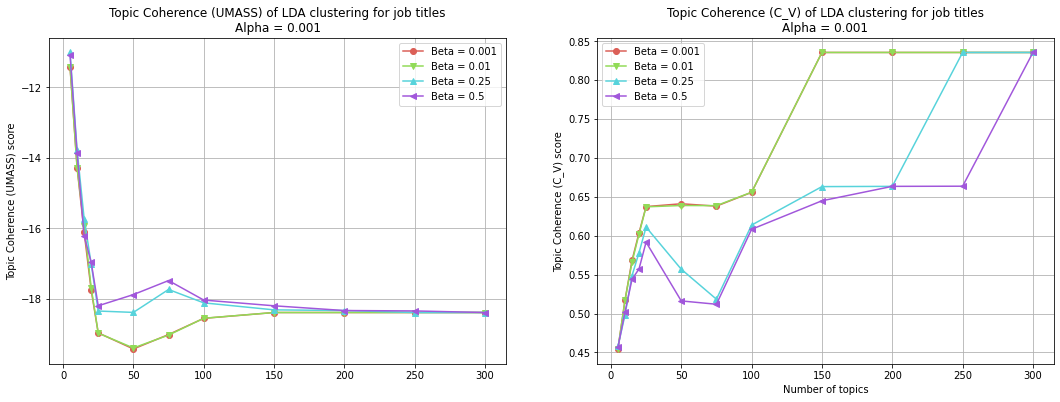

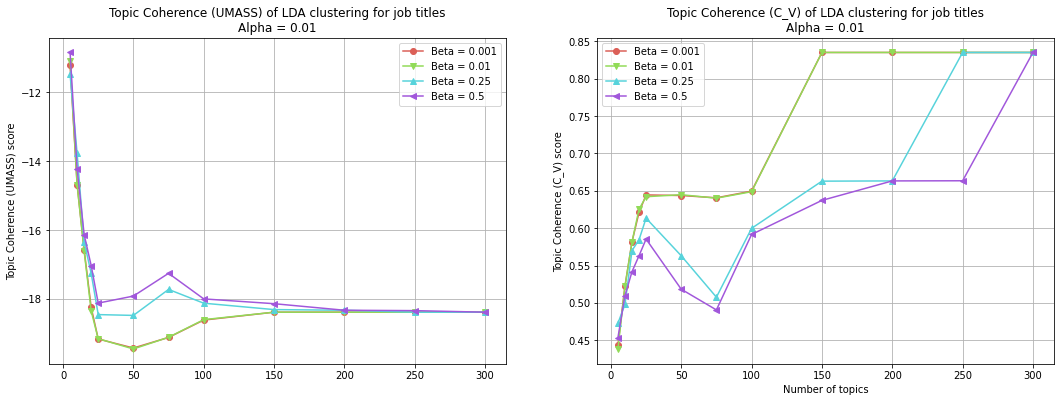

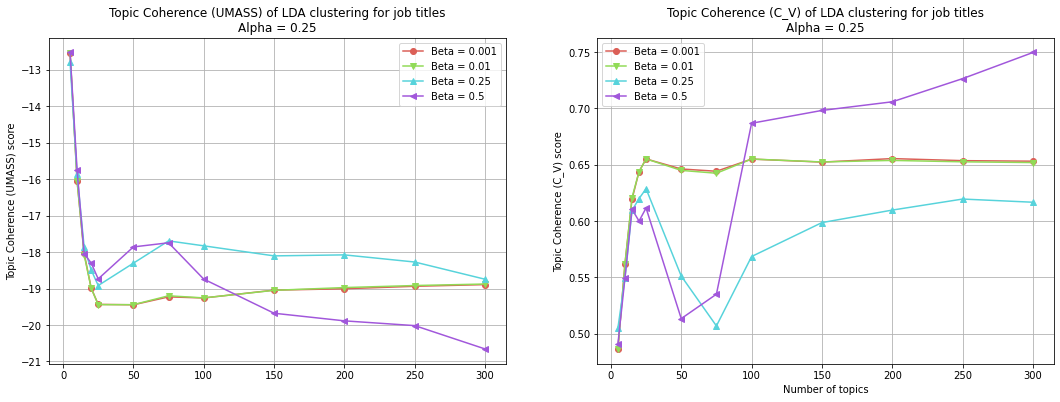

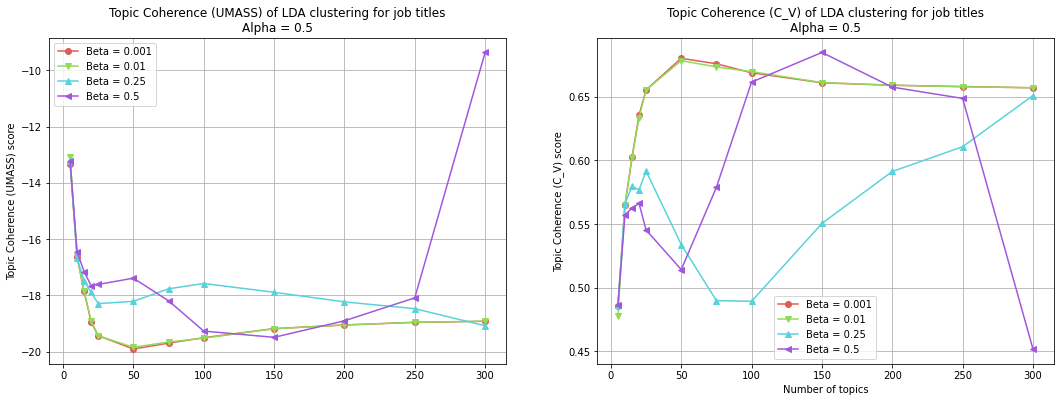

In [157]:
palette = sns.color_palette("hls", n_colors=len(beta_range))

# The higher the better

for ida, alpha in enumerate(alpha_range):
    fig = plt.figure(figsize=(18, 6))
    for idx, beta in enumerate(beta_range):
        # Plot UMASS coherence
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["coherence_umass"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax1.set_ylabel("Topic Coherence (UMASS) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax1.set_title(
            "Topic Coherence (UMASS) of LDA clustering for job titles\n"
            + "Alpha = "
            + str(alpha)
        )
        ax1.legend(loc="best")

        # Plot C_V coherence
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["coherence_cv"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax2.set_ylabel("Topic Coherence (C_V) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax2.set_title(
            "Topic Coherence (C_V) of LDA clustering for job titles\n"
            + "Alpha = "
            + str(alpha)
        )
        ax2.set_xlabel("Number of topics")
        # plt.yticks(np.unique(model_result_df["number_clusters"]))

        ax2.legend(loc="best")
    ax1.grid()
    ax2.grid()

    # Saving plot as image
    fig.savefig(
        RESULT_DIR
        + "lda/"
        + "title_lda_coherence_alpha-"
        + str(alpha)
        + "_plot.png",
        #     bbox_inches="tight",
        #     dpi=150,
    )

    # Show plot
    plt.show()

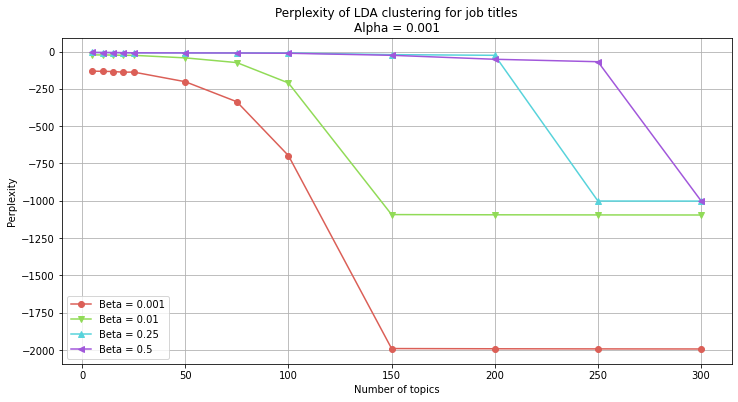

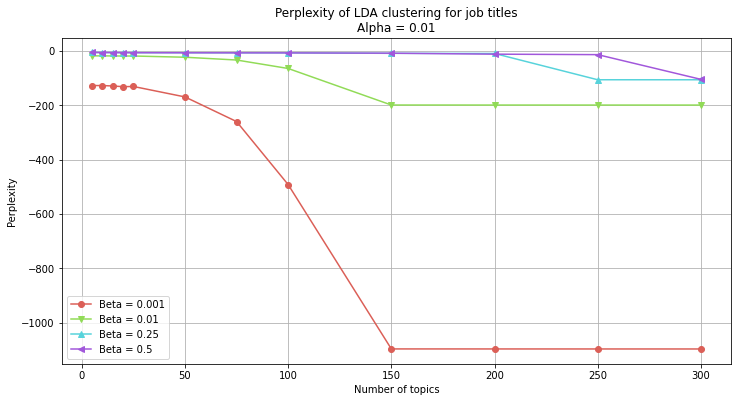

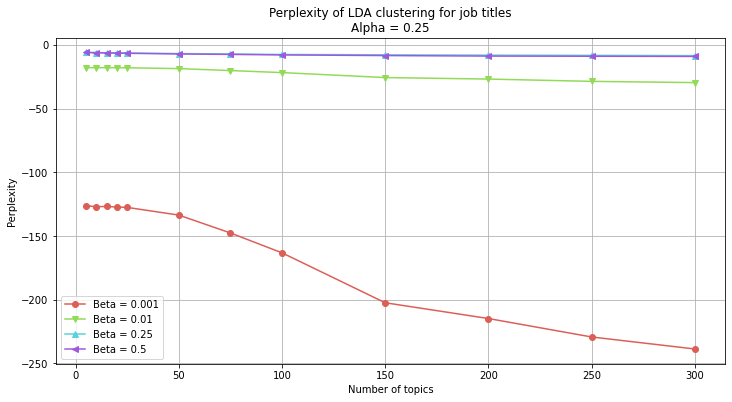

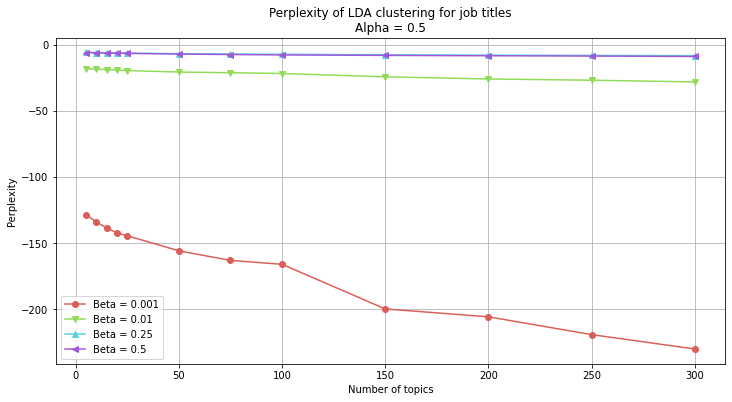

In [158]:
palette = sns.color_palette("hls", n_colors=len(beta_range))

# The higher the better
for ida, alpha in enumerate(alpha_range):
    fig = plt.figure(figsize=(12, 6))
    for idx, beta in enumerate(beta_range):
        plt.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["perplexity"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
    plt.xlabel("Number of topics")
    # plt.yticks(np.unique(model_result_df["number_clusters"]))
    plt.ylabel("Perplexity")
    # plt.xticks(np.unique(model_result_df["min_samples"]))
    plt.title("Perplexity of LDA clustering for job titles\n" + "Alpha = " + str(alpha))
    plt.legend(loc="best")
    plt.grid()

    # Saving plot as image
    fig.savefig(
        RESULT_DIR + "lda/" + "title_lda_perplexity_alpha-" + str(alpha) + "_plot.png",
        #     bbox_inches="tight",
        #     dpi=150,
    )

    # Show plot
    plt.show()

In [189]:
# Select the LDA model with optimal number of topics
# best_index = np.argmax(tuning_result_df["coherence_cv"].values)
best_index = int(
    np.where(
        (np.array(tuning_result["alpha"]) == 0.001)
        & (np.array(tuning_result["beta"]) == 0.001)
        & (np.array(tuning_result["n_topics"]) == 25)
    )[0]
)
print("Index of best coherence score", best_index)
best_n_topics = tuning_result_df["n_topics"][best_index]
best_alpha = tuning_result_df["alpha"][best_index]
best_beta = tuning_result_df["beta"][best_index]

print(
    f"Optimal number of topics = {best_n_topics}, best alpha = {best_alpha}, best beta = {best_beta}"
)
# best_lda_model = build_lda_model(
#     dictionary=id2word,
#     corpus=lda_corpus,
#     n_topics=best_n_topics,
#     alpha=best_alpha,
#     beta=best_beta,
# )
best_lda_model = model_list[best_index]

Index of best coherence score 64
Optimal number of topics = 25, best alpha = 0.001, best beta = 0.001


In [190]:
# Get topic weights
topic_weights = []
for i, row_list in tqdm(
    iterable=enumerate(best_lda_model[lda_corpus]),
    desc="Get LDA topic weights",
    total=len(best_lda_model[lda_corpus]),
):
    #     print(i)
    #     print(row_list)
#     if len(row_list) > 0:
    topic_weights.append([w for i, w in row_list])
#     else:
#         topic_weights.append([0])
#     print()

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

Get LDA topic weights: 100%|███████████████████████████████████████████████████| 18992/18992 [00:02<00:00, 6780.46it/s]


In [191]:
arr.shape

(18992, 25)

In [192]:
np.asarray(topic_weights).shape

(18992, 25)

In [193]:
np.asarray(topic_weights)[:10, :10]

array([[3.3057932e-04, 3.3057932e-04, 3.3057932e-04, 3.3057932e-04,
        3.3057932e-04, 3.3057932e-04, 3.3057932e-04, 3.3090946e-01,
        3.3090860e-01, 3.3057932e-04],
       [1.6600043e-04, 1.6600043e-04, 1.6600043e-04, 1.6616069e-01,
        1.6600043e-04, 1.6600043e-04, 1.6600043e-04, 1.6600043e-04,
        1.6600043e-04, 1.6600043e-04],
       [4.9383059e-04, 4.9383059e-04, 4.9383059e-04, 4.9383059e-04,
        4.9383059e-04, 4.9383059e-04, 4.9383059e-04, 4.9383059e-04,
        4.9383059e-04, 4.9383059e-04],
       [9.7561005e-04, 9.7561005e-04, 9.7561005e-04, 9.7561005e-04,
        9.7561005e-04, 9.7561005e-04, 9.7561005e-04, 9.7561005e-04,
        9.7561005e-04, 9.7561005e-04],
       [9.8814815e-01, 4.9382751e-04, 4.9382751e-04, 4.9382751e-04,
        4.9382751e-04, 4.9382751e-04, 4.9382751e-04, 4.9382751e-04,
        4.9382751e-04, 4.9382751e-04],
       [4.0000003e-02, 4.0000003e-02, 4.0000003e-02, 4.0000003e-02,
        4.0000003e-02, 4.0000003e-02, 4.0000003e-02, 4.00

In [164]:
# topic_num

In [194]:
np.unique(topic_num)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [285]:
# Reduce dimensionality using t-SNE algorithm
# Compute PCA components
pca_datapoint, _, _ = compute_cluster_visualization(
    X=arr, pca=True, tsne=False, compute_umap=False, seed=SEED
)

Start PCA 2021-05-19 12:04:11.009793
End PCA 2021-05-19 12:04:11.101775
PCA duration 0:00:00.091982


In [286]:
# Compute t-SNE components
_, _, tsne_datapoint = compute_cluster_visualization(
    X=arr, pca=False, tsne=True, compute_umap=False, seed=SEED, perplexity=30
)

Start t-SNE 2021-05-19 12:04:17.329621
End t-SNE 2021-05-19 12:07:19.608329
t-SNE duration 0:03:02.278708


In [287]:
# Compute UMAP components
_, umap_datapoint, _ = compute_cluster_visualization(
    X=arr, pca=False, tsne=False, compute_umap=True, seed=SEED, perplexity=7
)

Start UMAP 2021-05-19 12:07:19.620330
UMAP(dens_frac=0.0, dens_lambda=0.0, n_neighbors=7, random_state=6886,
     verbose=True)
Construct fuzzy simplicial set
Wed May 19 12:07:19 2021 Finding Nearest Neighbors
Wed May 19 12:07:19 2021 Building RP forest with 12 trees
Wed May 19 12:07:21 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Wed May 19 12:07:34 2021 Finished Nearest Neighbor Search
Wed May 19 12:07:37 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed May 19 12:07:52 2021 Finished embedding
End UMAP 2021-05-19 12:07:52.051636
UMAP duration 0:00:32.431306


In [288]:
# Save PCA and t-SNE dimensionality reduced data to file
np.save(OUTPUT_DIR + "visualization/" + "title_lda_pca_datapoints", pca_datapoint)
np.save(OUTPUT_DIR + "visualization/" + "title_lda_umap_datapoints", umap_datapoint)
np.save(OUTPUT_DIR + "visualization/" + "title_lda_tsne_datapoints", tsne_datapoint)

Start PCA 2021-05-19 12:07:52.260622
End PCA 2021-05-19 12:07:52.266611
PCA duration 0:00:00.005989

Start t-SNE 2021-05-19 12:07:52.267612
End t-SNE 2021-05-19 12:07:52.271647
t-SNE duration 0:00:00.004035

Start UMAP 2021-05-19 12:07:52.271647
End UMAP 2021-05-19 12:07:52.276649
UMAP duration 0:00:00.005002



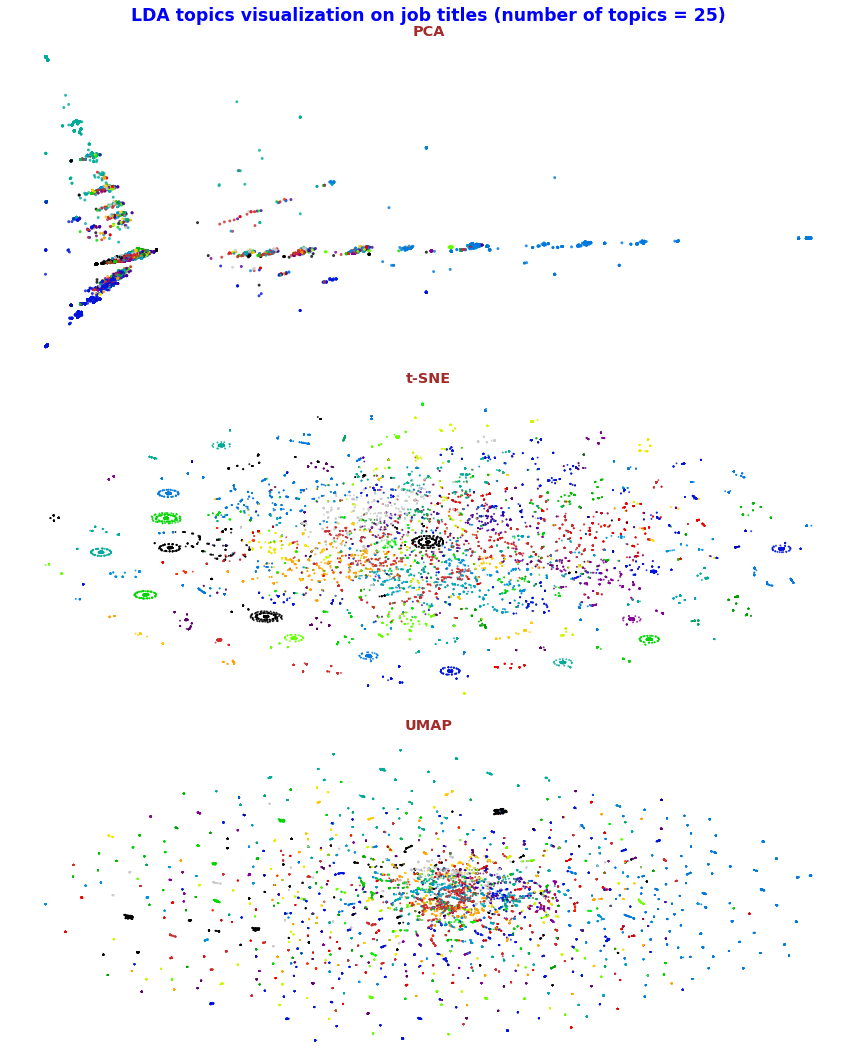

In [289]:
plot_title = (
    "LDA topics visualization on job titles (number of topics = "
    + str(best_n_topics)
    + ")"
)
plot_filename = (
    RESULT_DIR + "lda/" + "title_lda_optimal-cluster-visualization-topics.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = topic_num

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint,
    tsne_datapoint,
    umap_datapoint,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

In [214]:
# Finding the dominant topic in each document
def format_topics_sentences(ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(
        iterable=enumerate(best_lda_model[corpus]),
        desc="Find dominant topic of each document",
        total=len(best_lda_model[corpus]),
    ):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
#     sent_topics_df.reset_index(inplace=True)
#     contents.reset_index(inplace=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list
)

In [218]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,7.0,0.3309,"officer, credit, procurement, pr, driver, lend...",chief financial officer
1,20.0,0.3321,"database, regional, policy, associate, trainer...",time community connection intern pay internship
2,24.0,0.4943,"expert, coordinator, program, national, econom...",country coordinator
3,23.0,0.9766,"specialist, marketing, mobile, lead, planning,...",bcc specialist
4,0.0,0.9881,"developer, sale, software, net, asp, senior, c...",software developer
...,...,...,...,...
18987,6.0,0.4943,"senior, engineer, developer, software, qa, jav...",senior creative ux ui designer
18988,5.0,0.4943,"manager, sale, office, tax, area, brand, opera...",category development manager
18989,5.0,0.6350,"manager, sale, office, tax, area, brand, opera...",operational marketing manager
18990,8.0,0.4972,"department, analyst, financial, unit, head, op...",head online sale department


In [222]:
# Format
df_dominant_topic = df_topic_sents_keywords.copy(deep=True)
df_dominant_topic.reset_index(drop=True, inplace=True)
df_dominant_topic.columns = [
#     "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

print(df_dominant_topic.shape, df_topic_sents_keywords.shape)

(18992, 4) (18992, 4)


In [223]:
# Show
df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,7.0,0.3309,"officer, credit, procurement, pr, driver, lend...",chief financial officer
1,20.0,0.3321,"database, regional, policy, associate, trainer...",time community connection intern pay internship
2,24.0,0.4943,"expert, coordinator, program, national, econom...",country coordinator
3,23.0,0.9766,"specialist, marketing, mobile, lead, planning,...",bcc specialist
4,0.0,0.9881,"developer, sale, software, net, asp, senior, c...",software developer
...,...,...,...,...
18987,6.0,0.4943,"senior, engineer, developer, software, qa, jav...",senior creative ux ui designer
18988,5.0,0.4943,"manager, sale, office, tax, area, brand, opera...",category development manager
18989,5.0,0.6350,"manager, sale, office, tax, area, brand, opera...",operational marketing manager
18990,8.0,0.4972,"department, analyst, financial, unit, head, op...",head online sale department


In [310]:
df_clusters = pd.concat(
    [
        title_docs,
        df_dominant_topic[["Dominant_Topic", "Topic_Perc_Contrib", "Keywords"]],
    ],
    axis=1,
)
print(df_clusters.shape)
df_clusters

(18992, 7)


,job_id,job_title,job_title_lemma,job_title_token,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,1,Chief Financial Officer,chief financial officer,"[chief, financial, officer]",7.0,0.3309,"officer, credit, procurement, pr, driver, lend..."
1,2,Full-time Community Connections Intern (paid i...,time community connection intern pay internship,"[time, community, connection, intern, pay, int...",20.0,0.3321,"database, regional, policy, associate, trainer..."
2,3,Country Coordinator,country coordinator,"[country, coordinator]",24.0,0.4943,"expert, coordinator, program, national, econom..."
3,4,BCC Specialist,bcc specialist,"[bcc, specialist]",23.0,0.9766,"specialist, marketing, mobile, lead, planning,..."
4,5,Software Developer,software developer,"[software, developer]",0.0,0.9881,"developer, sale, software, net, asp, senior, c..."
...,...,...,...,...,...,...,...
18987,18997,Senior Creative UX/ UI Designer,senior creative ux ui designer,"[senior, creative, ux, ui, designer]",6.0,0.4943,"senior, engineer, developer, software, qa, jav..."
18988,18998,Category Development Manager,category development manager,"[category, development, manager]",5.0,0.4943,"manager, sale, office, tax, area, brand, opera..."
18989,18999,Operational Marketing Manager,operational marketing manager,"[operational, marketing, manager]",5.0,0.6350,"manager, sale, office, tax, area, brand, opera..."
18990,19000,Head of Online Sales Department,head online sale department,"[head, online, sale, department]",8.0,0.4972,"department, analyst, financial, unit, head, op..."


In [311]:
# Reorganize the dataframe
# df_clusters.insert(4, "n_clusters", best_n_topics)
df_clusters['n_clusters'] = best_n_topics
df_clusters.rename(
    columns={
        "Dominant_Topic": "title_cluster_label",
        "Topic_Perc_Contrib": "topic_perc_contrib",
        "Keywords": "topic_keywords",
    },
    inplace=True,
)

df_clusters = df_clusters[[
    "job_id",
    "job_title",
    "job_title_lemma",
    "job_title_token",
    "n_clusters",
    "title_cluster_label",
    "topic_perc_contrib",
    "topic_keywords",
]]
df_clusters[['title_cluster_label']] = df_clusters[['title_cluster_label']].applymap(int)
df_clusters

,job_id,job_title,job_title_lemma,job_title_token,n_clusters,title_cluster_label,topic_perc_contrib,topic_keywords
0,1,Chief Financial Officer,chief financial officer,"[chief, financial, officer]",25,7,0.3309,"officer, credit, procurement, pr, driver, lend..."
1,2,Full-time Community Connections Intern (paid i...,time community connection intern pay internship,"[time, community, connection, intern, pay, int...",25,20,0.3321,"database, regional, policy, associate, trainer..."
2,3,Country Coordinator,country coordinator,"[country, coordinator]",25,24,0.4943,"expert, coordinator, program, national, econom..."
3,4,BCC Specialist,bcc specialist,"[bcc, specialist]",25,23,0.9766,"specialist, marketing, mobile, lead, planning,..."
4,5,Software Developer,software developer,"[software, developer]",25,0,0.9881,"developer, sale, software, net, asp, senior, c..."
...,...,...,...,...,...,...,...,...
18987,18997,Senior Creative UX/ UI Designer,senior creative ux ui designer,"[senior, creative, ux, ui, designer]",25,6,0.4943,"senior, engineer, developer, software, qa, jav..."
18988,18998,Category Development Manager,category development manager,"[category, development, manager]",25,5,0.4943,"manager, sale, office, tax, area, brand, opera..."
18989,18999,Operational Marketing Manager,operational marketing manager,"[operational, marketing, manager]",25,5,0.6350,"manager, sale, office, tax, area, brand, opera..."
18990,19000,Head of Online Sales Department,head online sale department,"[head, online, sale, department]",25,8,0.4972,"department, analyst, financial, unit, head, op..."


In [224]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in tqdm(
    iterable=sent_topics_outdf_grpd,
    desc="Find representative document for each topic",
    total=len(sent_topics_outdf_grpd),
):
    sent_topics_sorted_df = pd.concat(
        [
            sent_topics_sorted_df,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

print(sent_topics_sorted_df.shape)

Find representative document for each topic: 100%|████████████████████████████████████| 25/25 [00:00<00:00, 891.68it/s]

(25, 4)


In [225]:
# Show
sent_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9952,"developer, sale, software, net, asp, senior, c...",asp net senior software developer
1,1.0,0.9940,"consultant, php, developer, programmer, superv...",flash action scripting programmer html coder
2,2.0,0.9952,"project, quality, translator, control, coordin...",tester engineer quality assurance qc engineer
3,3.0,0.9952,"development, training, program, billing, commu...",community development capacity building conflict
4,4.0,0.9940,"agent, advertising, content, environmental, re...",volunteer registration request process
5,5.0,0.9921,"manager, sale, office, tax, area, brand, opera...",area sale manager
6,6.0,0.9952,"senior, engineer, developer, software, qa, jav...",java architect java senior developer
7,7.0,0.9921,"officer, credit, procurement, pr, driver, lend...",th graduate study programme
8,8.0,0.9921,"department, analyst, financial, unit, head, op...",head financial department
9,9.0,0.9921,"assistant, administrative, representative, med...",receptionist administrative assistant


In [241]:
# Topic distribution across documents

# Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords["Dominant_Topic"].value_counts()
topic_counts = df_topic_sents_keywords[["Dominant_Topic", "Text"]].groupby(["Dominant_Topic"]).count()
print(topic_counts.shape, end=" ")
topic_counts.columns = ['Num_Documents']
# topic_counts

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts / topic_counts.sum(), 4)
print(topic_contribution.shape, end=" ")
topic_contribution.columns = ['Perc_Documents']
# topic_contribution

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[["Dominant_Topic", "Topic_Keywords"]]
topic_num_keywords.drop_duplicates(inplace=True)
# topic_num_keywords.set_index(topic_num_keywords['Dominant_Topic'], inplace=True)
# topic_num_keywords.rename(index="")
topic_num_keywords.sort_values(by=['Dominant_Topic'], ascending=True, inplace=True)
topic_num_keywords.reset_index(drop=True, inplace=True)
print(topic_num_keywords.shape, end=" ")
# topic_num_keywords

# Concatenate Column wise
# topic_counts.reset_index(inplace=True, drop=True)
# topic_contribution.reset_index(inplace=True, drop=True)
# topic_num_keywords.reset_index(inplace=True, drop=True)

df_dominant_topics = pd.concat(
    [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

# Change Column names
df_dominant_topics.columns = [
    "Dominant_Topic",
    "Topic_Keywords",
    "Num_Documents",
    "Perc_Documents",
]

# df_dominant_topics.dropna(subset=['Num_Documents'], inplace=True)
df_dominant_topics.sort_values(by=['Num_Documents'], ascending=False, inplace=True)
df_dominant_topics.reset_index(drop=True, inplace=True)

print(df_dominant_topics.shape)

In [259]:
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"senior, engineer, developer, software, qa, jav...",2240,0.1179
1,5.0,"manager, sale, office, tax, area, brand, opera...",2026,0.1067
2,23.0,"specialist, marketing, mobile, lead, planning,...",1711,0.0901
3,0.0,"developer, sale, software, net, asp, senior, c...",1399,0.0737
4,9.0,"assistant, administrative, representative, med...",1331,0.0701
5,13.0,"accountant, chief, team, leader, cashier, cent...",1025,0.0540
6,7.0,"officer, credit, procurement, pr, driver, lend...",823,0.0433
7,19.0,"service, division, technical, head, support, c...",737,0.0388
8,24.0,"expert, coordinator, program, national, econom...",730,0.0384
9,8.0,"department, analyst, financial, unit, head, op...",696,0.0366


In [272]:
X = title_embeddings
best_labels = df_dominant_topic["Dominant_Topic"].values
model_validation = {"n_topics": [best_n_topics], "alpha": [best_alpha], "beta": [best_alpha]}

In [273]:
model_validation["silhouette"] = []
model_validation["silhouette_error"] = []

try:
    silhouette = metrics.silhouette_score(
        X, best_labels, sample_size=10000, random_state=SEED, n_jobs=-1
    )
    model_validation["silhouette_error"].append("None")
except Exception as e:
    print(e)
    silhouette = -1.1
    model_validation["silhouette_error"].append(e)
model_validation["silhouette"].append(silhouette)

In [274]:
model_validation["calinski_harabasz"] = []
model_validation["calinski_harabasz_error"] = []

try:
    calinski_harabasz = metrics.calinski_harabasz_score(X, best_labels)
    model_validation["calinski_harabasz_error"].append("None")
except Exception as e:
    print(e)
    calinski_harabasz = -1.1
    model_validation["calinski_harabasz_error"].append(e)
model_validation["calinski_harabasz"].append(calinski_harabasz)

In [275]:
model_validation["davies_bouldin"] = []
model_validation["davies_bouldin_error"] = []

try:
    davies_bouldin = metrics.davies_bouldin_score(X, best_labels)
    model_validation["davies_bouldin_error"].append("None")
except Exception as e:
    print(e)
    davies_bouldin = -1.1
    model_validation["davies_bouldin_error"].append(e)
model_validation["davies_bouldin"].append(davies_bouldin)

In [276]:
model_validation["silhouette_corr"] = []
model_validation["silhouette_corr_error"] = []

try:
    silhouette = metrics.silhouette_score(
        X,
        best_labels,
        sample_size=10000,
        random_state=SEED,
        n_jobs=-1,
        metric="correlation",
    )
    model_validation["silhouette_corr_error"].append("None")
except Exception as e:
    print(e)
    silhouette = -1.1
    model_validation["silhouette_corr_error"].append(e)
model_validation["silhouette_corr"].append(silhouette)

In [277]:
# Display validation results
model_validation_df = pd.DataFrame(model_validation)
model_validation_df

,n_topics,alpha,beta,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,25,0.001,0.001,0.036961,None,249.231304,None,3.874049,None,0.0,None


In [278]:
# Save tuning results
model_validation_df.to_csv(
    RESULT_DIR + "lda/" + "title_lda_model_validation.csv", index=False
)

In [279]:
pca_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "title_pca_datapoints.npy")
umap_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "title_umap_datapoints.npy")
tsne_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "title_tsne_datapoints.npy")

Start PCA 2021-05-19 12:03:31.207774
End PCA 2021-05-19 12:03:31.226835
PCA duration 0:00:00.019061

Start t-SNE 2021-05-19 12:03:31.226835
End t-SNE 2021-05-19 12:03:31.232829
t-SNE duration 0:00:00.005994

Start UMAP 2021-05-19 12:03:31.232829
End UMAP 2021-05-19 12:03:31.238818
UMAP duration 0:00:00.005989



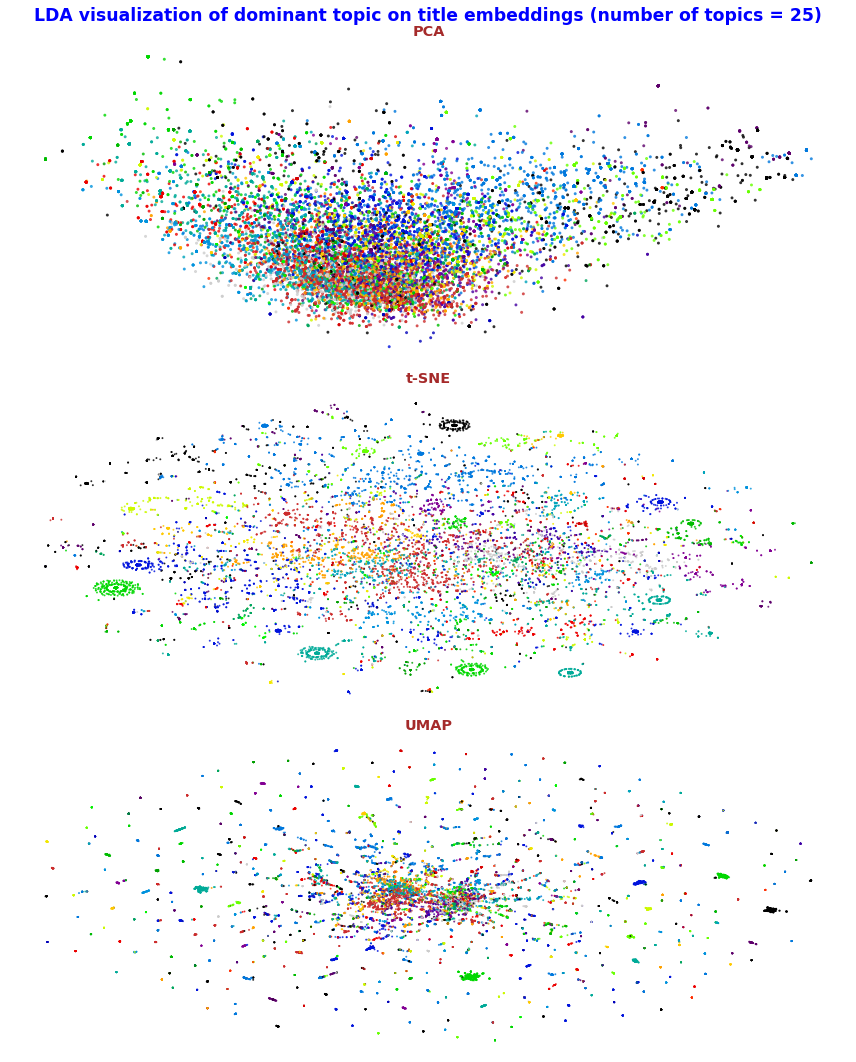

In [280]:
plot_title = (
    "LDA visualization of dominant topic on title embeddings (number of topics = "
    + str(best_n_topics)
    + ")"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
plot_filename = (
    RESULT_DIR + "lda/" + "title_lda_optimal-cluster-visualization-embeddings.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = best_labels

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint_raw,
    tsne_datapoint_raw,
    umap_datapoint_raw,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

## Save cluster results to file

In [281]:
sent_topics_sorted_df.to_csv(
    RESULT_DIR + "lda/" + "title_lda_optimal-represent-doc-per-topic.csv", index=False
)

In [282]:
df_dominant_topics.to_csv(
    RESULT_DIR + "lda/" + "title_lda_optimal-topic-distribution.csv", index=False
)

In [312]:
df_clusters.to_csv(
    RESULT_DIR + "lda/" + "title_lda_optimal-cluster-labels.csv", index=False
)

In [313]:
# Save tuple of model sets
pickle.dump(
    (
        arr,
        sent_topics_sorted_df,
        df_dominant_topics,
        df_clusters,
    ),
    open(RESULT_DIR + "lda/" + "title_lda_model_topic_list.pkl", "wb"),
)